In [1]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,matplotlib,sklearn,pandas,torch,autogluon

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.27.0

numpy     : 1.26.4
scipy     : 1.13.1
matplotlib: 3.9.2
sklearn   : 1.5.2
pandas    : 2.1.4
torch     : 2.3.0
autogluon : 1.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
CPU cores   : 12
Architecture: 64bit



### Loading Model , Libraries and Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from torch.utils.data import DataLoader
import torch
# Load datasets

train_dataset = torch.load('data/train_dataset.pt')
val_dataset = torch.load('data/val_dataset.pt')
test_dataset = torch.load('data/test_dataset.pt')

In [4]:
def tensor_to_dataframe(tensor_dataset, feature_names=None, target_name='target'):
    """Convert PyTorch TensorDataset to Pandas DataFrame."""
    X_tensor, y_tensor = tensor_dataset.tensors
    X = X_tensor.numpy()
    y = y_tensor.numpy()

    feature_names = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

    df = pd.DataFrame(X, columns=feature_names)
    df[target_name] = y  # Add target column

    return df

# Convert PyTorch datasets to Pandas DataFrames
train_df = tensor_to_dataframe(train_dataset)
val_df = tensor_to_dataframe(val_dataset)
test_df = tensor_to_dataframe(test_dataset)

# Display the first few rows of the training set
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-0.293480,-0.539023,0.639396,1.052636,2
1,1.000297,-0.078881,0.809938,1.449739,2
2,-1.116793,-1.229235,0.412007,0.655534,2
3,1.000297,0.151189,0.355160,0.258432,1
4,-0.999177,1.071472,-1.407104,-1.197610,0


In [5]:
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-1.704873,-0.078881,-1.407104,-1.329978,0
1,0.294600,-0.078881,0.639396,0.787901,2
2,-1.116793,-1.459306,-0.270160,-0.271038,1
3,-0.999177,-1.689376,-0.270160,-0.271038,1
4,-1.704873,0.381260,-1.407104,-1.329978,0


### Autogluon

Autogluon is an open-source machine learning (ML) library that automates the ML process. It was developed by Amazon Web Services (AWS). 

In [6]:
%pip install autogluon -q

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Manual Mode

In [8]:
import autogluon.core as ag

def train_manual_mode(train_data,val_data, batch_size, learning_rate, num_epochs):
    """Train model using manual hyperparameters in AutoGluon."""
    
    nn_options = {
        'num_epochs': num_epochs,  
        'learning_rate': learning_rate,    
        'batch_size': batch_size,  
        'hidden_size': 16,  
        'num_layers': 2,  
        'activation': 'relu'
    }
    
    hyperparameters = {
        'NN_TORCH': nn_options
    }
    
    model_path = f'models/manual_training/bs{batch_size}_lr{learning_rate}_epochs{num_epochs}'
    
    predictor = TabularPredictor(
        label='target',  
        problem_type='multiclass',
        verbosity=1,
        eval_metric='accuracy',  
        path=model_path,
    ).fit(
        train_data=train_data,
        tuning_data=val_data,
        use_bag_holdout=True,  # Use validation data for tuning 
        # disable bagging
        num_bag_folds=0,
        # disable weighted ensembling
        num_stack_levels=0,
        fit_weighted_ensemble =False,
        fit_full_last_level_weighted_ensemble= False,
        
        verbosity=2,
        hyperparameters=hyperparameters,
        time_limit=20*60,
        presets='best_quality',
    )
    
    return predictor

In [9]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from autogluon.common import space

def evaluate_model(predictor, test_data):
    """Evaluate the trained model on test data."""
    print("Evaluating model...")
    y_pred = predictor.predict(test_data.drop(columns=['target']))  
    y_true = test_data['target']

    accuracy = (y_pred == y_true).mean()
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}\n")
    
    # Confusion Matrix Plot
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predictor.class_labels, yticklabels=predictor.class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Print classification report
    print(classification_report(y_true, y_pred))
    
    # Show 5 sample predictions
    sample_indices = [1, 5, 10, 15, 20]
    for i in sample_indices:
        print(f"Sample {i}: Truth: {y_true.iloc[i]}, Predicted: {y_pred.iloc[i]}")
    
    print('-'*50)
    
    return accuracy, f1

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.15 GB / 15.68 GB (26.4%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1


Training with Batch Size: 2, Learning Rate: 0.001, Epochs: 1


Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs2_lr0.001_epochs1"
Train Data Rows:    105
Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4241.61 MB
	Train Data (Original)  Memory Usage: 0.00 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerato

*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch        0.8    accuracy       0.004012  2.273627                0.004012           2.273627            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.7333, F1 Score: 0.6936



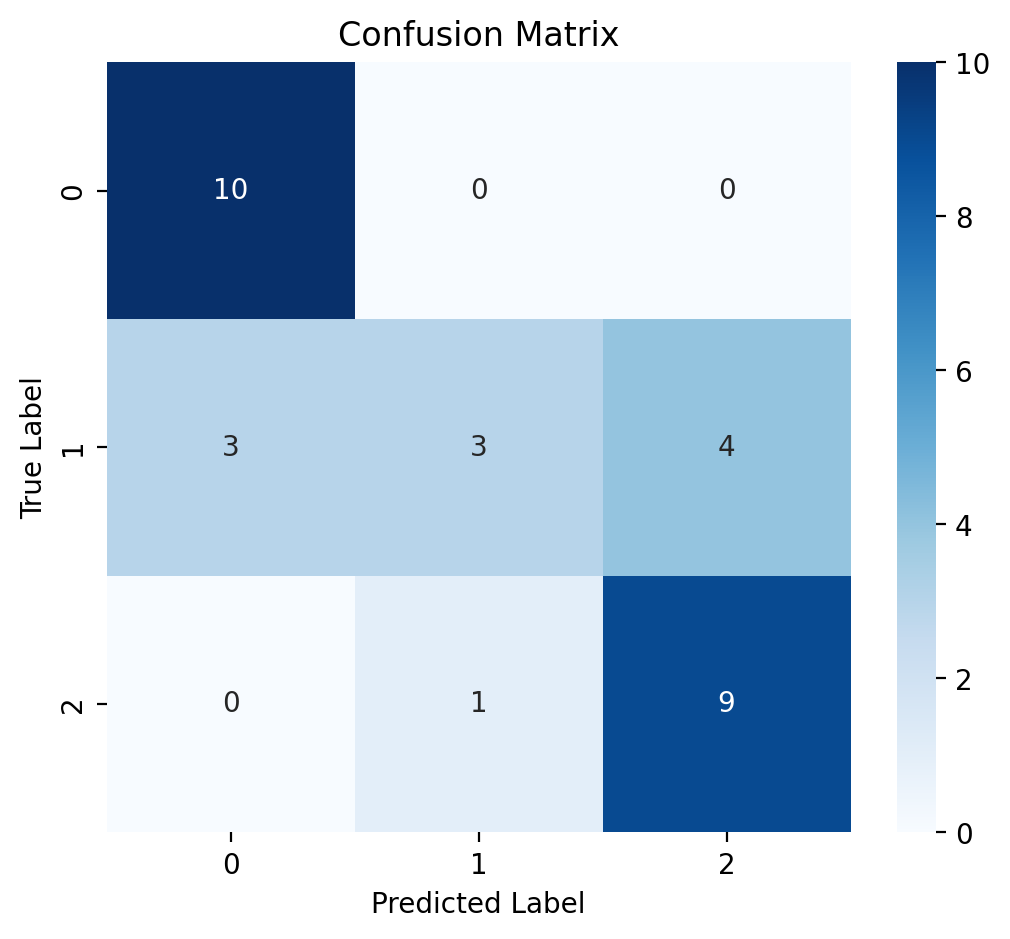

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.06 GB / 15.68 GB (25.9%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs2_lr0.001_epochs3"
Train Data Rows:    105
Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data 

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.75      0.30      0.43        10
           2       0.69      0.90      0.78        10

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.69        30
weighted avg       0.74      0.73      0.69        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Validation Accuracy: 0.8
Training with Batch Size: 2, Learning Rate: 0.001, Epochs: 3


	0.8	 = Validation score   (accuracy)
	0.37s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 0.45s ... Best model: NeuralNetTorch | Estimated inference throughput: 3991.5 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("d:\UserFiles\CS203_Lab_06\models\manual_training\bs2_lr0.001_epochs3")


*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch        0.8    accuracy       0.003758  0.374458                0.003758           0.374458            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.7000, F1 Score: 0.6105



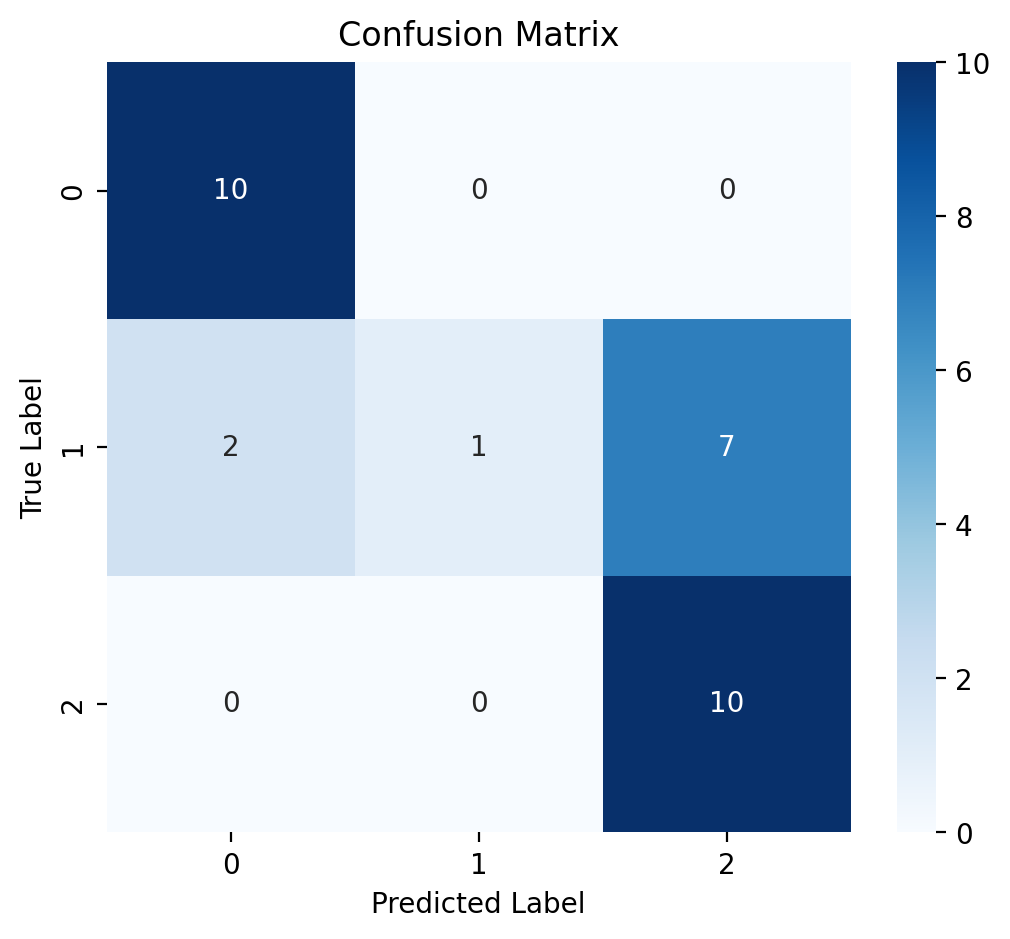

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.10      0.18        10
           2       0.59      1.00      0.74        10

    accuracy                           0.70        30
   macro avg       0.81      0.70      0.61        30
weighted avg       0.81      0.70      0.61        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.02 GB / 15.68 GB (25.6%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs2_lr0.001_epochs5"
Train Data Rows:    105
Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data 

Validation Accuracy: 0.8
Training with Batch Size: 2, Learning Rate: 0.001, Epochs: 5


	0.8667	 = Validation score   (accuracy)
	0.54s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 0.63s ... Best model: NeuralNetTorch | Estimated inference throughput: 2651.2 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("d:\UserFiles\CS203_Lab_06\models\manual_training\bs2_lr0.001_epochs5")


*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch   0.866667    accuracy       0.005658  0.542152                0.005658           0.542152            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.7667, F1 Score: 0.7341



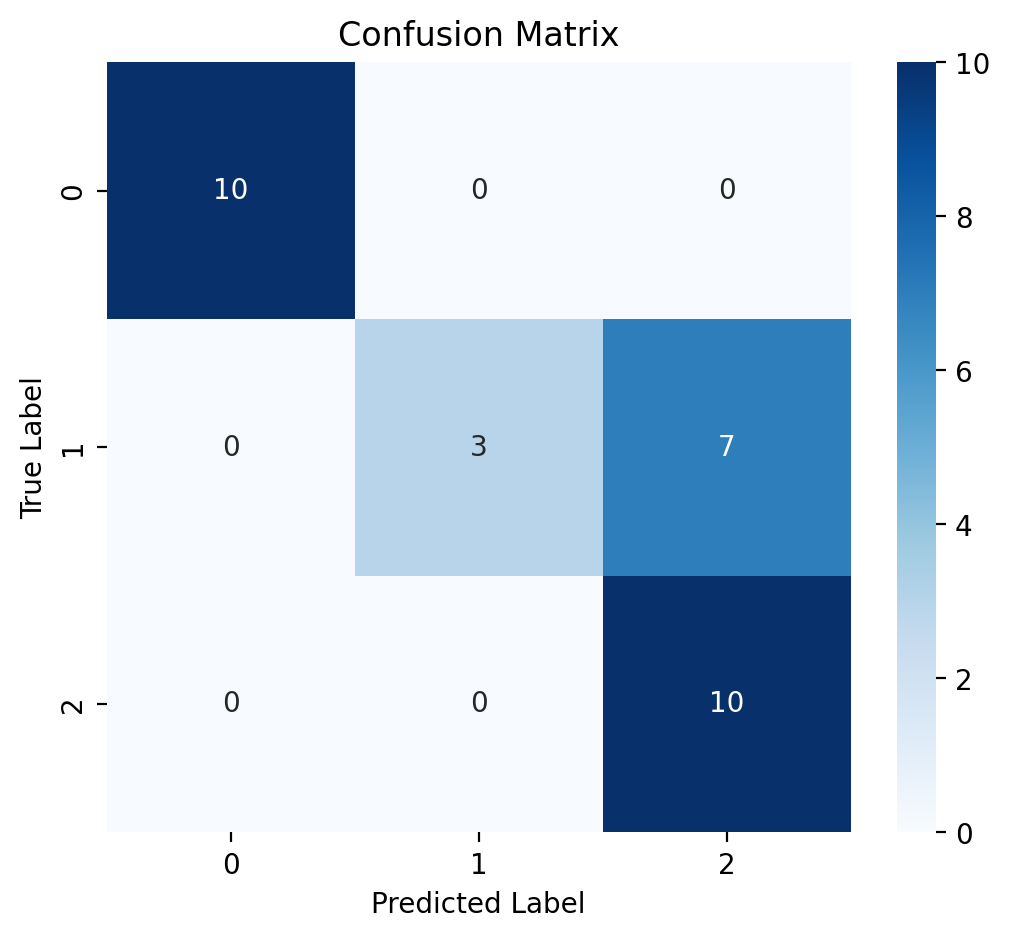

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.30      0.46        10
           2       0.59      1.00      0.74        10

    accuracy                           0.77        30
   macro avg       0.86      0.77      0.73        30
weighted avg       0.86      0.77      0.73        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Validation Accuracy: 0.8666666666666667
Training with Batch Size: 2, Learning Rate: 1e-05, Epochs: 1


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.04 GB / 15.68 GB (25.8%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs2_lr1e-05_epochs1"
Train Data Rows:    105
Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data 

*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch   0.266667    accuracy       0.004733  0.133036                0.004733           0.133036            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.4000, F1 Score: 0.3293



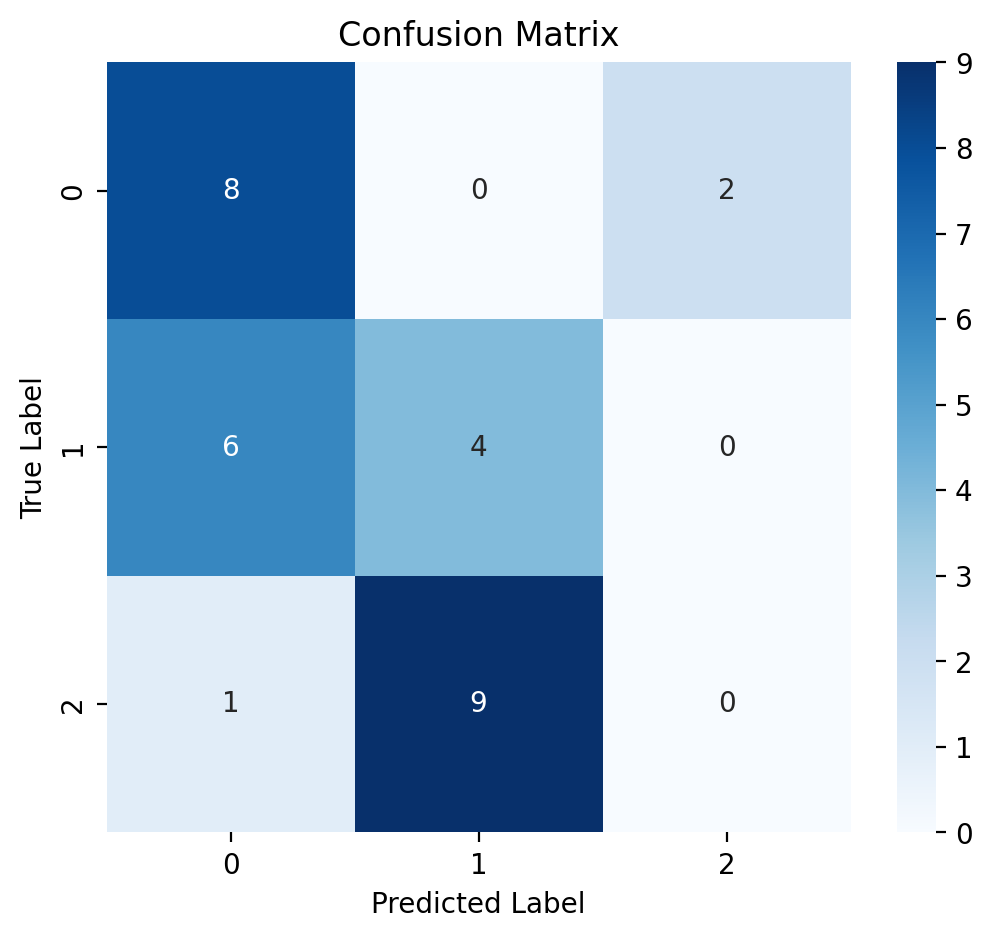

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.03 GB / 15.68 GB (25.7%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs2_lr1e-05_epochs3"
Train Data Rows:    105
Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data 

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.31      0.40      0.35        10
           2       0.00      0.00      0.00        10

    accuracy                           0.40        30
   macro avg       0.28      0.40      0.33        30
weighted avg       0.28      0.40      0.33        30

Sample 1: Truth: 2, Predicted: 1
Sample 5: Truth: 1, Predicted: 1
Sample 10: Truth: 2, Predicted: 1
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Validation Accuracy: 0.26666666666666666
Training with Batch Size: 2, Learning Rate: 1e-05, Epochs: 3


	0.3333	 = Validation score   (accuracy)
	0.35s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 0.43s ... Best model: NeuralNetTorch | Estimated inference throughput: 3704.1 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("d:\UserFiles\CS203_Lab_06\models\manual_training\bs2_lr1e-05_epochs3")


*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch   0.333333    accuracy        0.00405  0.350842                 0.00405           0.350842            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.4000, F1 Score: 0.3293



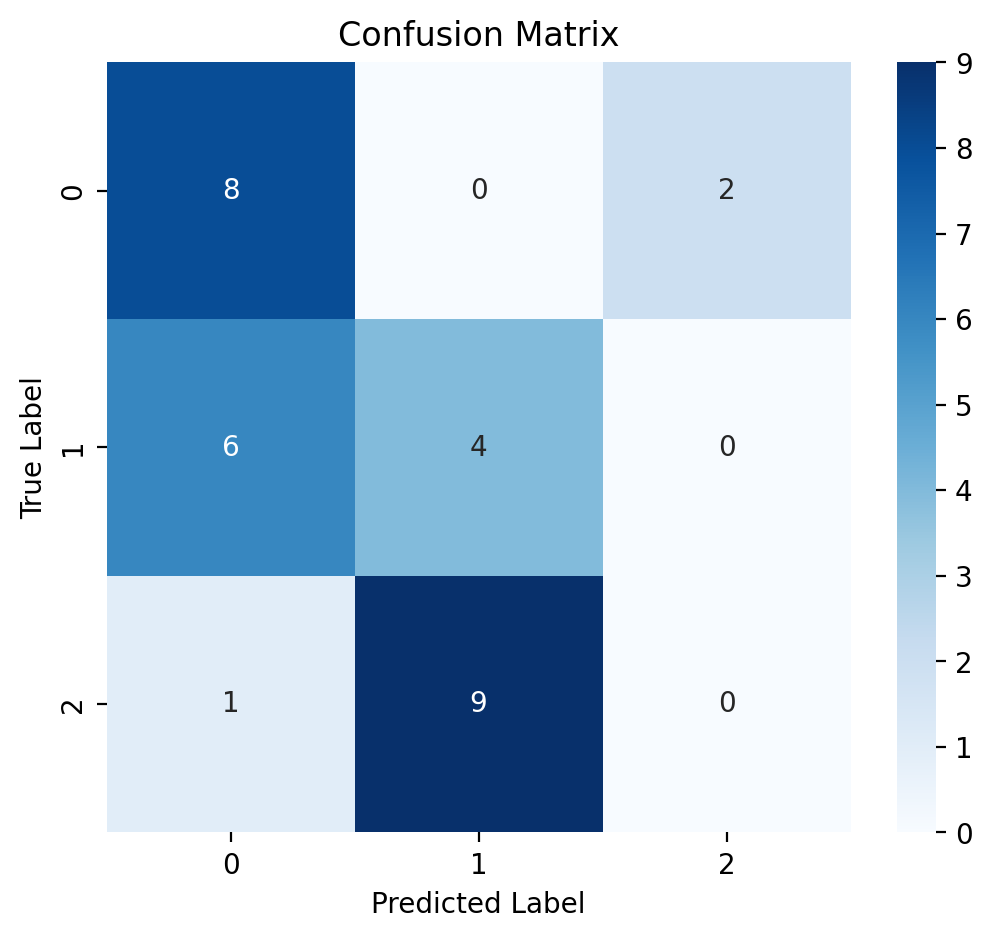

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.06 GB / 15.68 GB (25.9%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs2_lr1e-05_epochs5"
Train Data Rows:    105
Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data 

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.31      0.40      0.35        10
           2       0.00      0.00      0.00        10

    accuracy                           0.40        30
   macro avg       0.28      0.40      0.33        30
weighted avg       0.28      0.40      0.33        30

Sample 1: Truth: 2, Predicted: 1
Sample 5: Truth: 1, Predicted: 1
Sample 10: Truth: 2, Predicted: 1
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Validation Accuracy: 0.3333333333333333
Training with Batch Size: 2, Learning Rate: 1e-05, Epochs: 5


	0.3333	 = Validation score   (accuracy)
	0.56s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 0.62s ... Best model: NeuralNetTorch | Estimated inference throughput: 3718.8 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("d:\UserFiles\CS203_Lab_06\models\manual_training\bs2_lr1e-05_epochs5")


*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch   0.333333    accuracy       0.004034  0.563746                0.004034           0.563746            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.4000, F1 Score: 0.3293



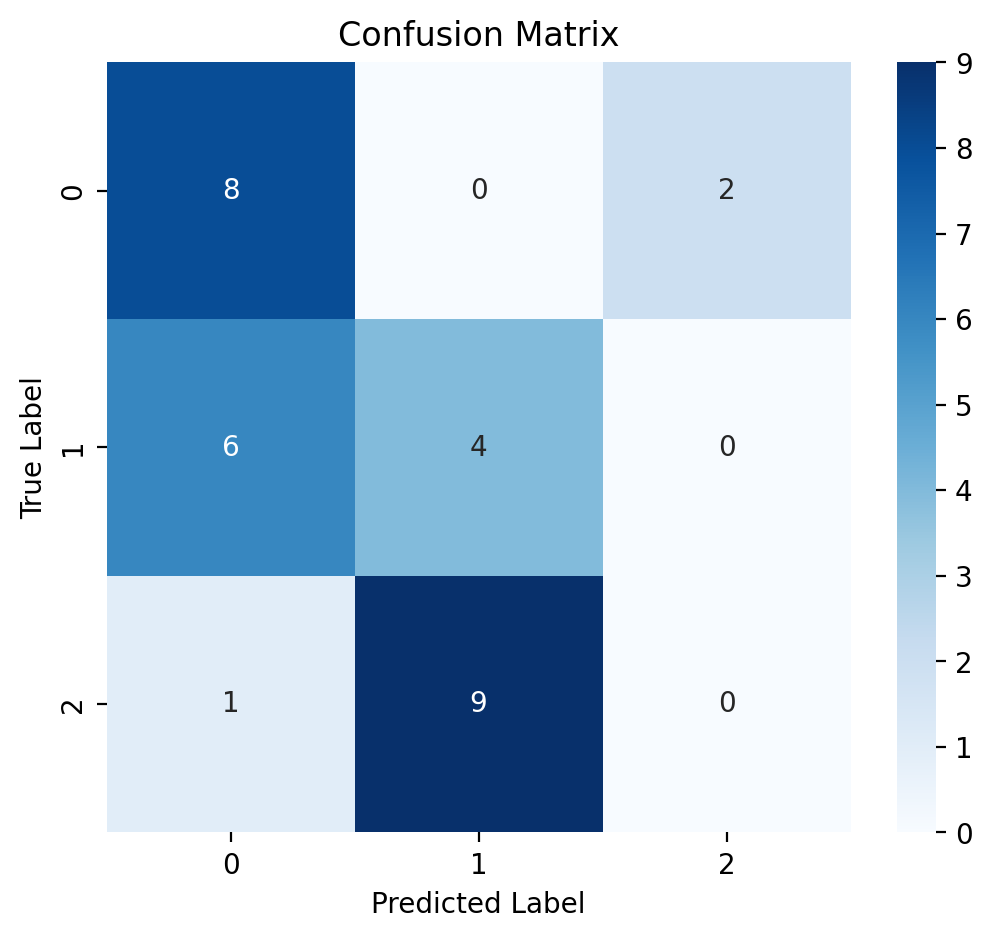

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.31      0.40      0.35        10
           2       0.00      0.00      0.00        10

    accuracy                           0.40        30
   macro avg       0.28      0.40      0.33        30
weighted avg       0.28      0.40      0.33        30

Sample 1: Truth: 2, Predicted: 1
Sample 5: Truth: 1, Predicted: 1
Sample 10: Truth: 2, Predicted: 1
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.05 GB / 15.68 GB (25.8%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs4_lr0.001_epochs1"
Train Data Rows:    105
Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data 

Validation Accuracy: 0.3333333333333333
Training with Batch Size: 4, Learning Rate: 0.001, Epochs: 1


TabularPredictor saved. To load, use: predictor = TabularPredictor.load("d:\UserFiles\CS203_Lab_06\models\manual_training\bs4_lr0.001_epochs1")


*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch   0.666667    accuracy       0.003544  0.076138                0.003544           0.076138            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.5667, F1 Score: 0.5316



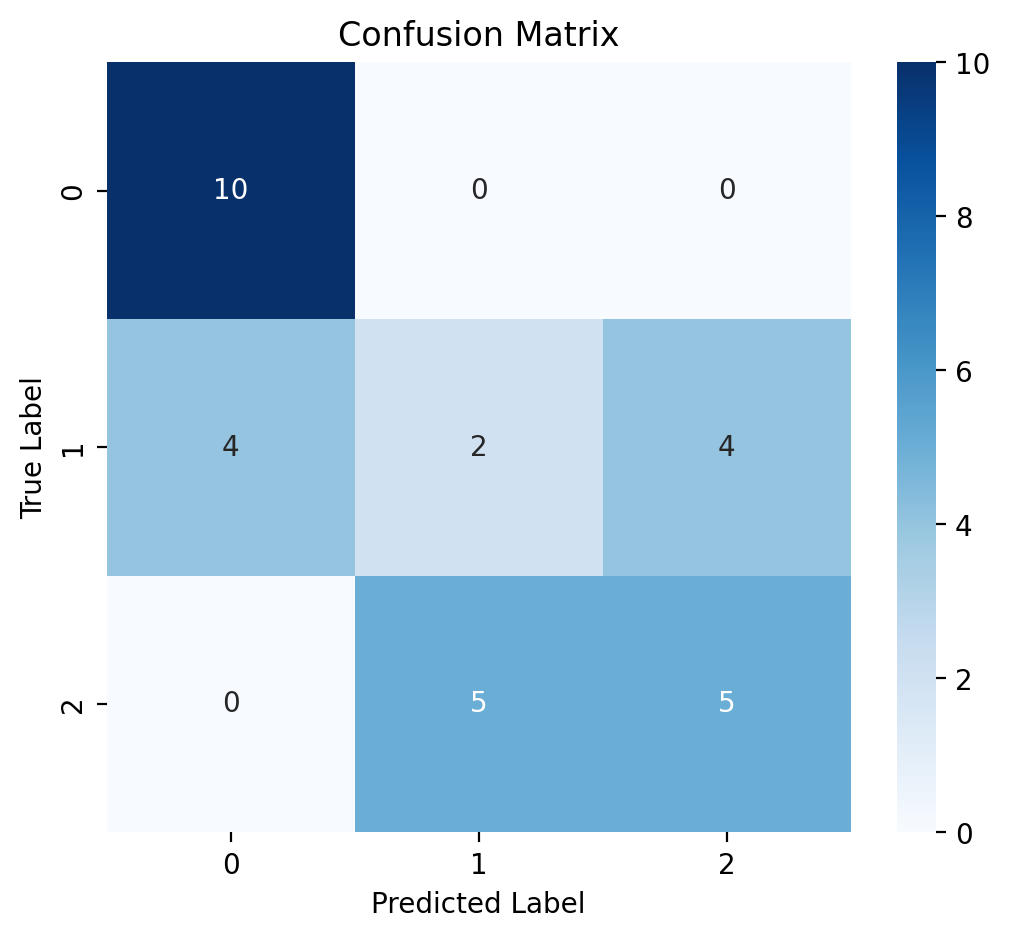

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.06 GB / 15.68 GB (25.9%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs4_lr0.001_epochs3"
Train Data Rows:    105
Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data 

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.29      0.20      0.24        10
           2       0.56      0.50      0.53        10

    accuracy                           0.57        30
   macro avg       0.52      0.57      0.53        30
weighted avg       0.52      0.57      0.53        30

Sample 1: Truth: 2, Predicted: 1
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Validation Accuracy: 0.6666666666666666
Training with Batch Size: 4, Learning Rate: 0.001, Epochs: 3


	0.7333	 = Validation score   (accuracy)
	0.18s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 0.25s ... Best model: NeuralNetTorch | Estimated inference throughput: 7472.0 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("d:\UserFiles\CS203_Lab_06\models\manual_training\bs4_lr0.001_epochs3")


*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch   0.733333    accuracy       0.002007  0.177202                0.002007           0.177202            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.6667, F1 Score: 0.5368



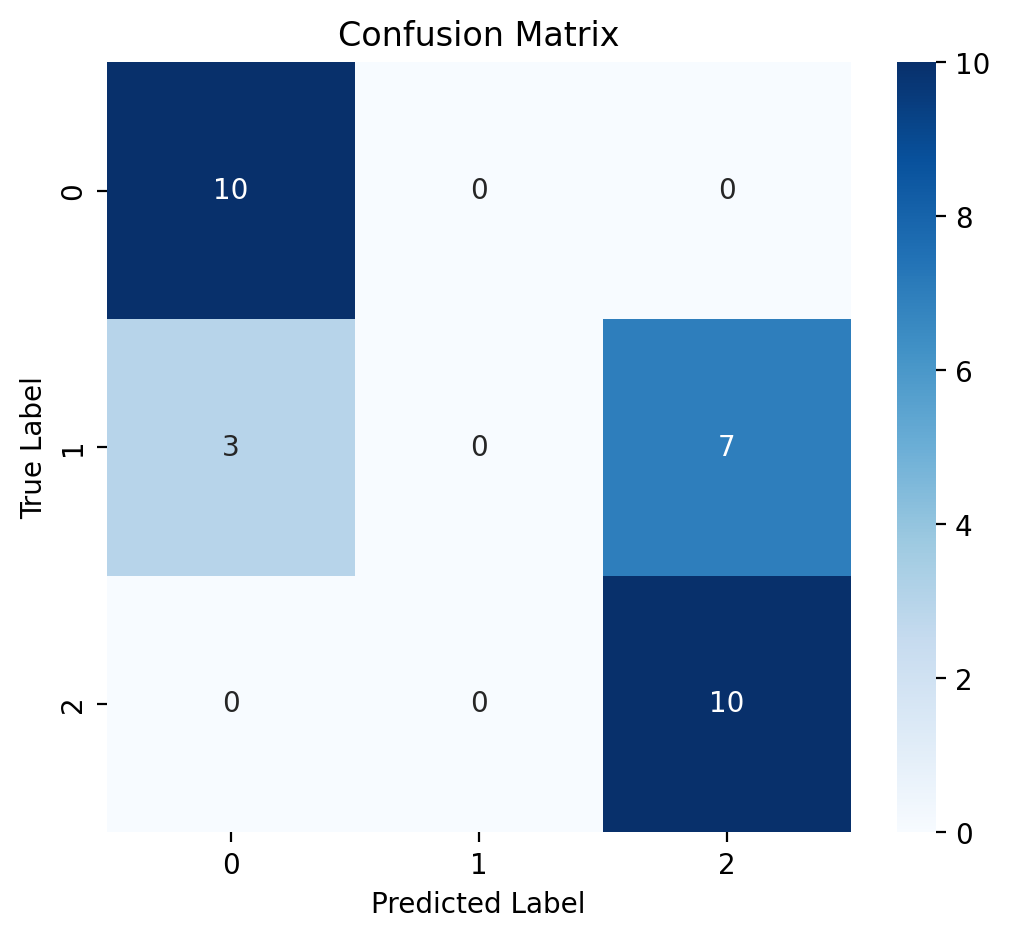

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.04 GB / 15.68 GB (25.7%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs4_lr0.001_epochs5"
Train Data Rows:    105


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.00      0.00      0.00        10
           2       0.59      1.00      0.74        10

    accuracy                           0.67        30
   macro avg       0.45      0.67      0.54        30
weighted avg       0.45      0.67      0.54        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Validation Accuracy: 0.7333333333333333
Training with Batch Size: 4, Learning Rate: 0.001, Epochs: 5


Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4128.24 MB
	Train Data (Original)  Memory Usage: 0.00 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
	T

*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch        0.8    accuracy       0.004025  0.311415                0.004025           0.311415            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.7000, F1 Score: 0.6105



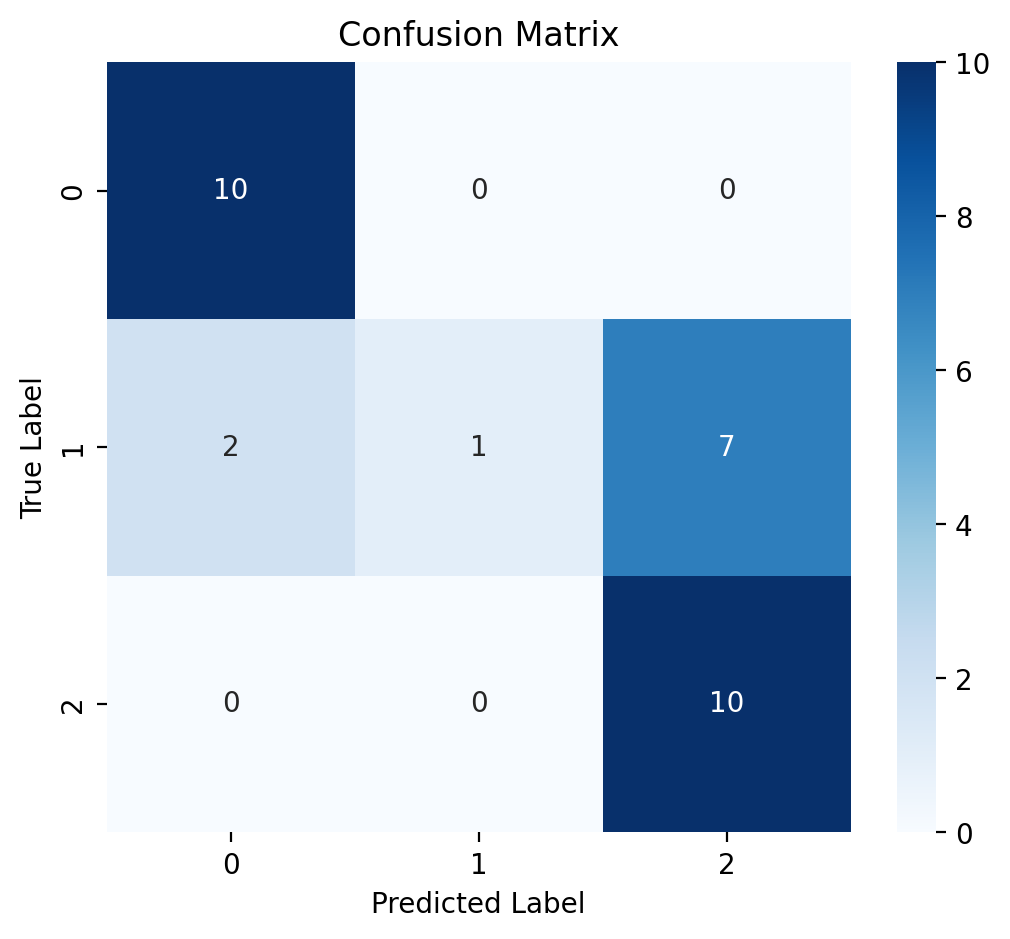

Verbosity: 2 (Standard Logging)


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.10      0.18        10
           2       0.59      1.00      0.74        10

    accuracy                           0.70        30
   macro avg       0.81      0.70      0.61        30
weighted avg       0.81      0.70      0.61        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Validation Accuracy: 0.8
Training with Batch Size: 4, Learning Rate: 1e-05, Epochs: 1


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.05 GB / 15.68 GB (25.8%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs4_lr1e-05_epochs1"
Train Data Rows:    105
Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatur

*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch   0.266667    accuracy       0.004007  0.086678                0.004007           0.086678            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.4000, F1 Score: 0.3293



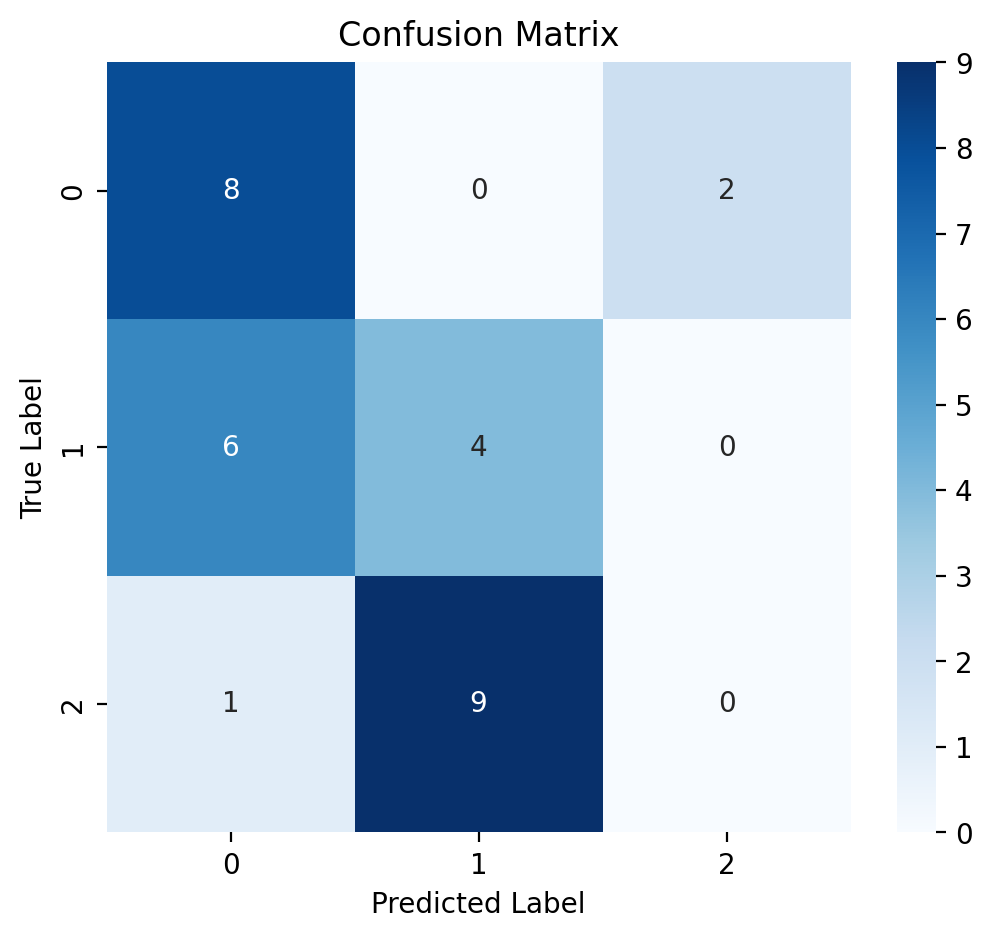

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.31      0.40      0.35        10
           2       0.00      0.00      0.00        10

    accuracy                           0.40        30
   macro avg       0.28      0.40      0.33        30
weighted avg       0.28      0.40      0.33        30

Sample 1: Truth: 2, Predicted: 1
Sample 5: Truth: 1, Predicted: 1
Sample 10: Truth: 2, Predicted: 1
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Validation Accuracy: 0.26666666666666666


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.05 GB / 15.68 GB (25.8%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs4_lr1e-05_epochs3"
Train Data Rows:    105
Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data 

Training with Batch Size: 4, Learning Rate: 1e-05, Epochs: 3


	0.2667	 = Validation score   (accuracy)
	0.2s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 0.27s ... Best model: NeuralNetTorch | Estimated inference throughput: 2915.4 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("d:\UserFiles\CS203_Lab_06\models\manual_training\bs4_lr1e-05_epochs3")


*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch   0.266667    accuracy       0.005145  0.199493                0.005145           0.199493            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.4000, F1 Score: 0.3293



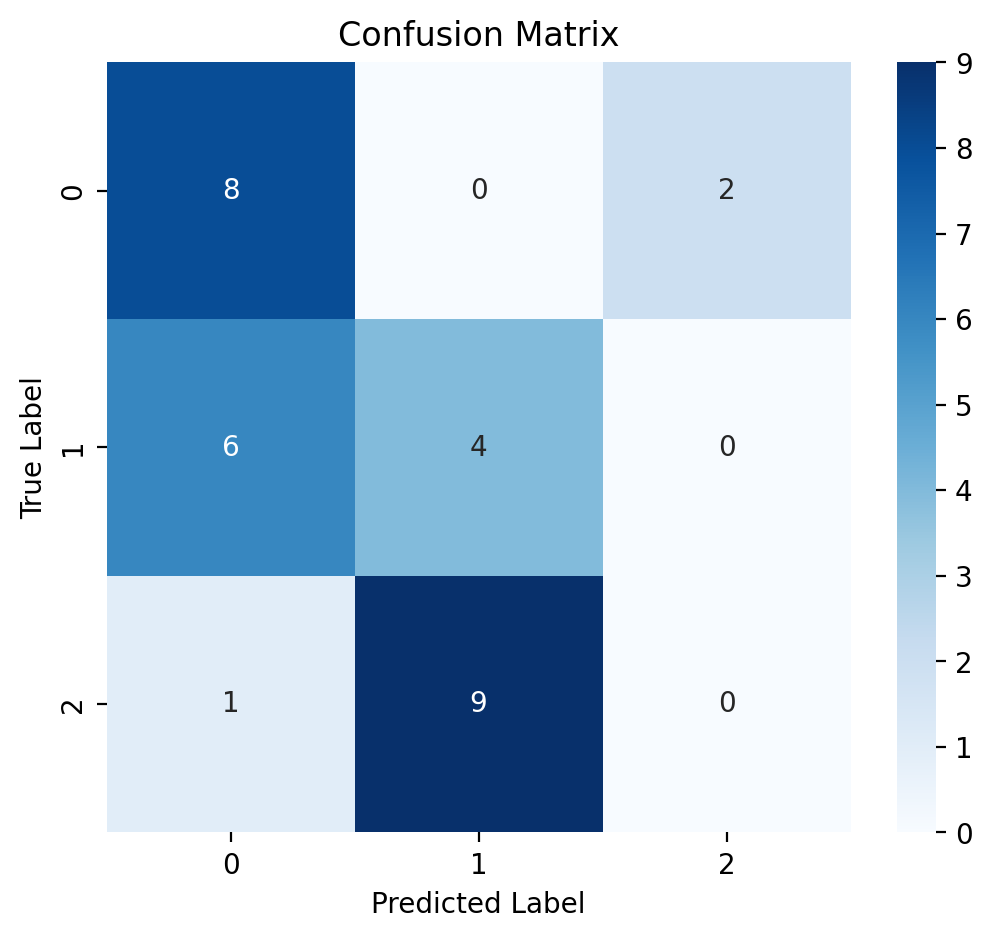

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.31      0.40      0.35        10
           2       0.00      0.00      0.00        10

    accuracy                           0.40        30
   macro avg       0.28      0.40      0.33        30
weighted avg       0.28      0.40      0.33        30

Sample 1: Truth: 2, Predicted: 1
Sample 5: Truth: 1, Predicted: 1
Sample 10: Truth: 2, Predicted: 1
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Validation Accuracy: 0.26666666666666666
Training with Batch Size: 4, Learning Rate: 1e-05, Epochs: 5


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.10 GB / 15.68 GB (26.2%)
Disk Space Avail:   80.96 GB / 100.00 GB (81.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "d:\UserFiles\CS203_Lab_06\models\manual_training\bs4_lr1e-05_epochs5"
Train Data Rows:    105
Train Data Columns: 4
Tuning Data Rows:    15
Tuning Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data 

*** Summary of fit() ***
Estimated performance of each model:
            model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch   0.333333    accuracy       0.004007  0.272156                0.004007           0.272156            1       True          1
Number of models trained: 1
Types of models trained:
{'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
*** End of fit() summary ***
Evaluating model...
Accuracy: 0.4000, F1 Score: 0.3293



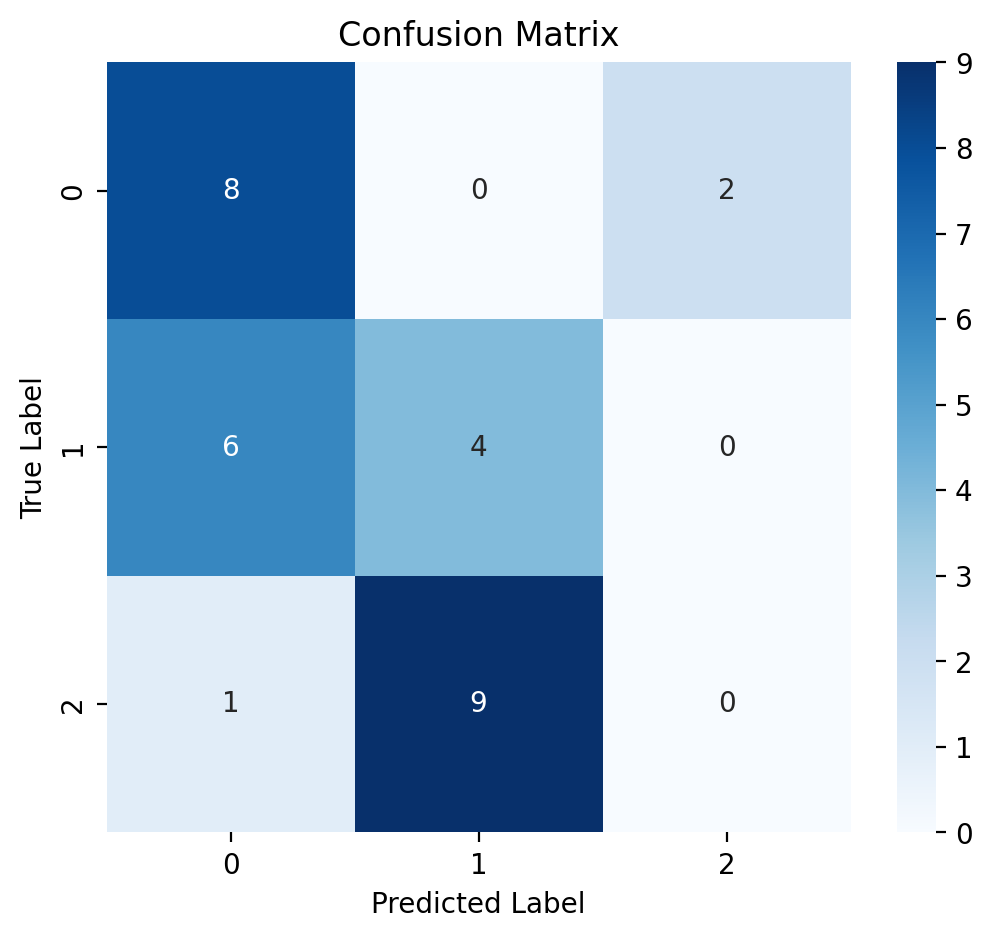

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.31      0.40      0.35        10
           2       0.00      0.00      0.00        10

    accuracy                           0.40        30
   macro avg       0.28      0.40      0.33        30
weighted avg       0.28      0.40      0.33        30

Sample 1: Truth: 2, Predicted: 1
Sample 5: Truth: 1, Predicted: 1
Sample 10: Truth: 2, Predicted: 1
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
Validation Accuracy: 0.3333333333333333


In [10]:
import os
import warnings
warnings.filterwarnings('ignore')
    
batch_sizes = [2, 4]
learning_rates = [1e-3, 1e-5]
epochs_list = [1, 3, 5]
# batch_sizes = [2]
# learning_rates = [1e-3]
# epochs_list = [3]

predictors = []
retrain = True
predictor_params = {}

results_table = pd.DataFrame(columns=['Batch Size', 'Learning Rate', 'Epochs', 'Test Accuracy','Validation Accuracy', 'F1 Score'])
   
for batch_size in batch_sizes:
    for lr in learning_rates:
        for epochs in epochs_list:
            if os.path.exists(f'models/manual_training/bs{batch_size}_lr{lr}_epochs{epochs}/predictor.pkl') and not retrain:
                print(f"Model already trained with Batch Size: {batch_size}, Learning Rate: {lr}, Epochs: {epochs}")
                predictor = TabularPredictor.load(f'models/manual_training/bs{batch_size}_lr{lr}_epochs{epochs}')
            else:
                print(f"Training with Batch Size: {batch_size}, Learning Rate: {lr}, Epochs: {epochs}")
                predictor = train_manual_mode(train_df,val_df,batch_size, lr, epochs)

            predictor.fit_summary()

            accuracy,f1 = evaluate_model(predictor,test_df)
            results_table.loc[len(results_table)] = {
                'Batch Size': batch_size, 
                'Learning Rate': lr, 
                'Epochs': epochs,
                'Test Accuracy': accuracy,
                'Validation Accuracy':predictor.leaderboard().loc[0, 'score_val'],
                'F1 Score': f1
            }
            print('Validation Accuracy:',predictor.leaderboard().loc[0, 'score_val'])
            predictors.append(predictor)

In [11]:
# sort result table by accuracy
results_table = results_table.sort_values(by='Test Accuracy', ascending=False)
display(results_table)

,Batch Size,Learning Rate,Epochs,Test Accuracy,Validation Accuracy,F1 Score
2,2,0.00100,5,0.766667,0.866667,0.734093
0,2,0.00100,1,0.733333,0.800000,0.693582
1,2,0.00100,3,0.700000,0.800000,0.610550
8,4,0.00100,5,0.700000,0.800000,0.610550
7,4,0.00100,3,0.666667,0.733333,0.536769
6,4,0.00100,1,0.566667,0.666667,0.531648
3,2,0.00001,1,0.400000,0.266667,0.329275
4,2,0.00001,3,0.400000,0.333333,0.329275
5,2,0.00001,5,0.400000,0.333333,0.329275
9,4,0.00001,1,0.400000,0.266667,0.329275


In [157]:
train_accuracies = []
for predictor in predictors:
    train_score = predictor.leaderboard(train_df).loc[0, 'score_test']  # Extract train accuracy
    train_accuracies.append(train_score)


results_table['Train Accuracy'] = train_accuracies
display(results_table)

,Batch Size,Learning Rate,Epochs,Test Accuracy,Validation Accuracy,F1 Score,Train Accuracy
2,2,0.00100,5,0.766667,0.866667,0.734093,0.723810
0,2,0.00100,1,0.733333,0.800000,0.693582,0.809524
1,2,0.00100,3,0.700000,0.800000,0.610550,0.866667
8,4,0.00100,5,0.700000,0.800000,0.610550,0.390476
7,4,0.00100,3,0.666667,0.733333,0.536769,0.390476
6,4,0.00100,1,0.566667,0.666667,0.531648,0.390476
3,2,0.00001,1,0.400000,0.266667,0.329275,0.609524
4,2,0.00001,3,0.400000,0.333333,0.329275,0.809524
5,2,0.00001,5,0.400000,0.333333,0.329275,0.809524
9,4,0.00001,1,0.400000,0.266667,0.329275,0.390476


In [12]:
print(len(predictors))

predictor1 = predictors[2]

models = predictor1.model_names()
print(models)
model = predictor1._trainer.load_model(models[0])
print(model)
# print(model.models)
predictor1.leaderboard()

12
['NeuralNetTorch']


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,0.866667,accuracy,0.005658,0.542152,0.005658,0.542152,1,True,1


In [13]:
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor.load("models/manual_training/bs2_lr0.001_epochs5")

model_names = predictor.model_names()
print("Models available:", model_names)

best_model = model_names[0]

model = predictor._trainer.load_model(best_model)

if hasattr(model, 'hyperparameters'):
    hp = model.hyperparameters
elif hasattr(model, '_hyperparameters'):
    hp = model._hyperparameters
elif hasattr(model, 'params'):
    hp = model.params
else:
    hp = "No hyperparameters attribute found."

print("Best model:", best_model)
print("Best hyperparameters:", hp)

Models available: ['NeuralNetTorch']
Best model: NeuralNetTorch
Best hyperparameters: {'num_epochs': 5, 'epochs_wo_improve': None, 'activation': 'relu', 'embedding_size_factor': 1.0, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.1, 'optimizer': 'adam', 'learning_rate': 0.001, 'weight_decay': 1e-06, 'proc.embed_min_categories': 4, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 100, 'proc.skew_threshold': 0.99, 'use_ngram_features': False, 'num_layers': 2, 'hidden_size': 16, 'max_batch_size': 512, 'use_batchnorm': False, 'loss_function': 'auto', 'batch_size': 2}


In [190]:
predictors[0].leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,0.8,accuracy,0.004012,2.273627,0.004012,2.273627,1,True,1


In [193]:

results_table2 = pd.DataFrame(columns=['Batch Size', 'Learning Rate', 'Epochs', 'Train Accuracy', 'Test Accuracy', 'Validation Accuracy', 'F1 Score', 'Model'])

for i in range(len(predictors)):
    predictor = predictors[i]
    leaderboard = predictor.leaderboard()
    model_name = predictor._trainer.load_model(leaderboard.loc[0, 'model'])
    val_score =  predictor.leaderboard().loc[0, 'score_val']
    train_score = predictor.leaderboard(train_df).loc[0, 'score_test']
    test_score = predictor.leaderboard(test_df).loc[0, 'score_test']

    hp = model_name.params

    results_table2.loc[len(results_table2)] = {
        'Batch Size': hp.get('batch_size', 'N/A'),
        'Learning Rate': hp.get('learning_rate', 'N/A'),
        'Epochs': hp.get('num_epochs', 'N/A'),
        'Train Accuracy': train_score,
        'Test Accuracy': test_score,
        'Validation Accuracy': val_score,
        'F1 Score': f1,
        'Model': leaderboard.loc[0, 'model']
    }

display(results_table2)


,Batch Size,Learning Rate,Epochs,Train Accuracy,Test Accuracy,Validation Accuracy,F1 Score,Model
0,2,0.00100,1,0.723810,0.733333,0.800000,0.329275,NeuralNetTorch
1,2,0.00100,3,0.809524,0.700000,0.800000,0.329275,NeuralNetTorch
2,2,0.00100,5,0.866667,0.766667,0.866667,0.329275,NeuralNetTorch
3,2,0.00001,1,0.390476,0.400000,0.266667,0.329275,NeuralNetTorch
4,2,0.00001,3,0.390476,0.400000,0.333333,0.329275,NeuralNetTorch
5,2,0.00001,5,0.390476,0.400000,0.333333,0.329275,NeuralNetTorch
6,4,0.00100,1,0.609524,0.566667,0.666667,0.329275,NeuralNetTorch
7,4,0.00100,3,0.809524,0.666667,0.733333,0.329275,NeuralNetTorch
8,4,0.00100,5,0.809524,0.700000,0.800000,0.329275,NeuralNetTorch
9,4,0.00001,1,0.390476,0.400000,0.266667,0.329275,NeuralNetTorch


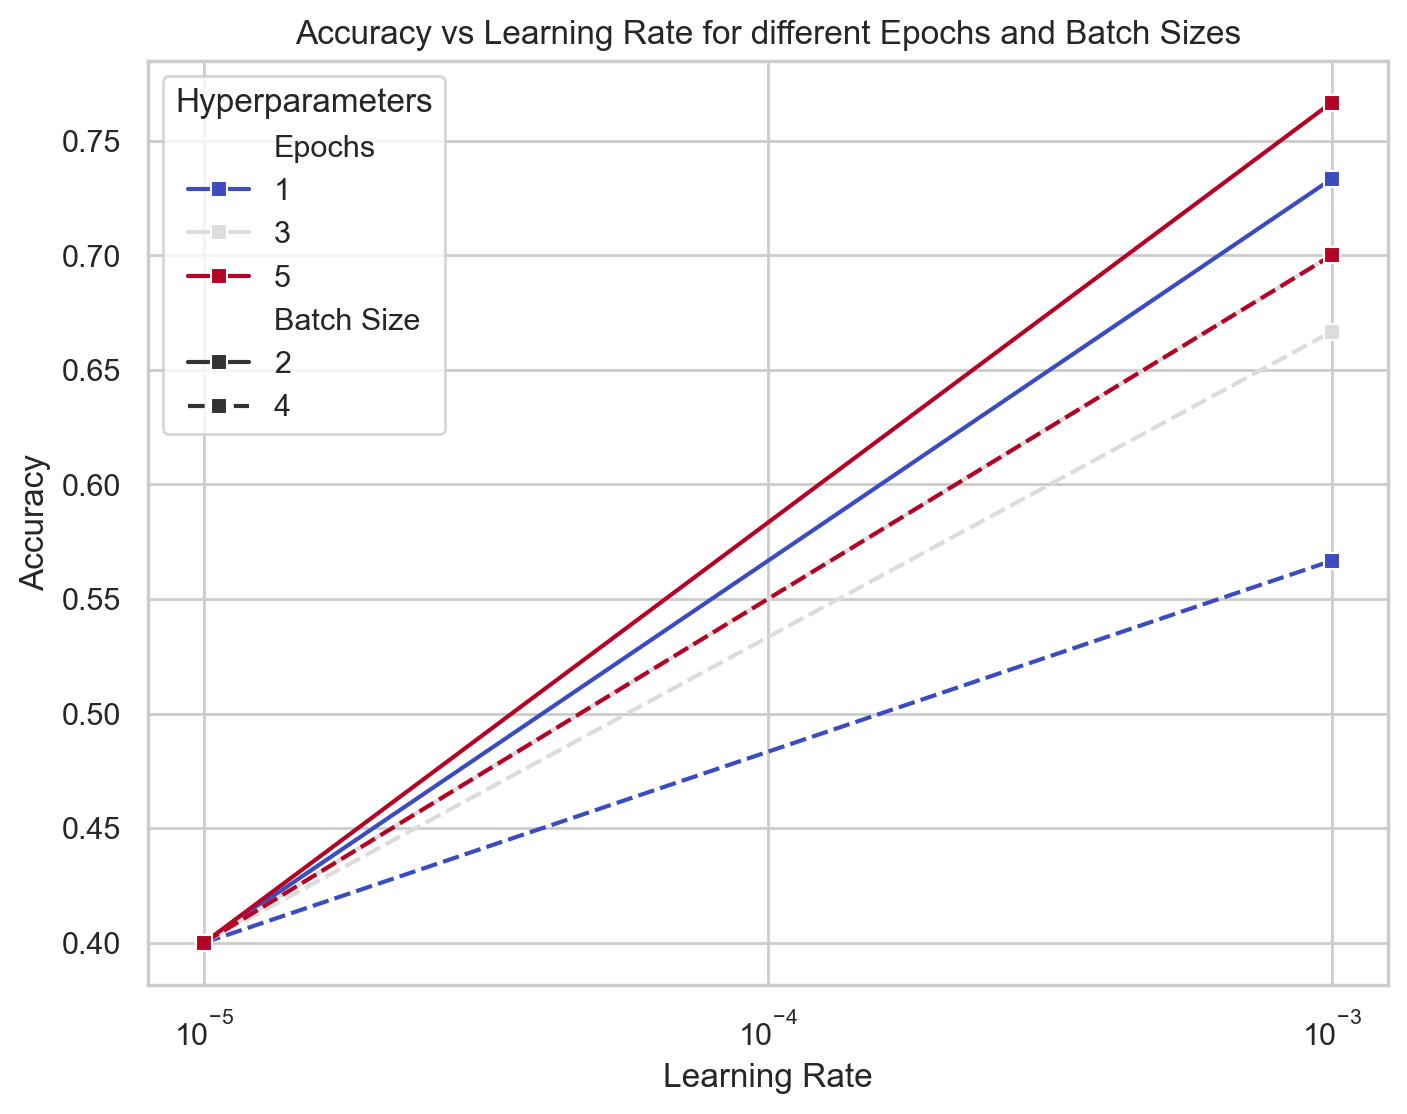

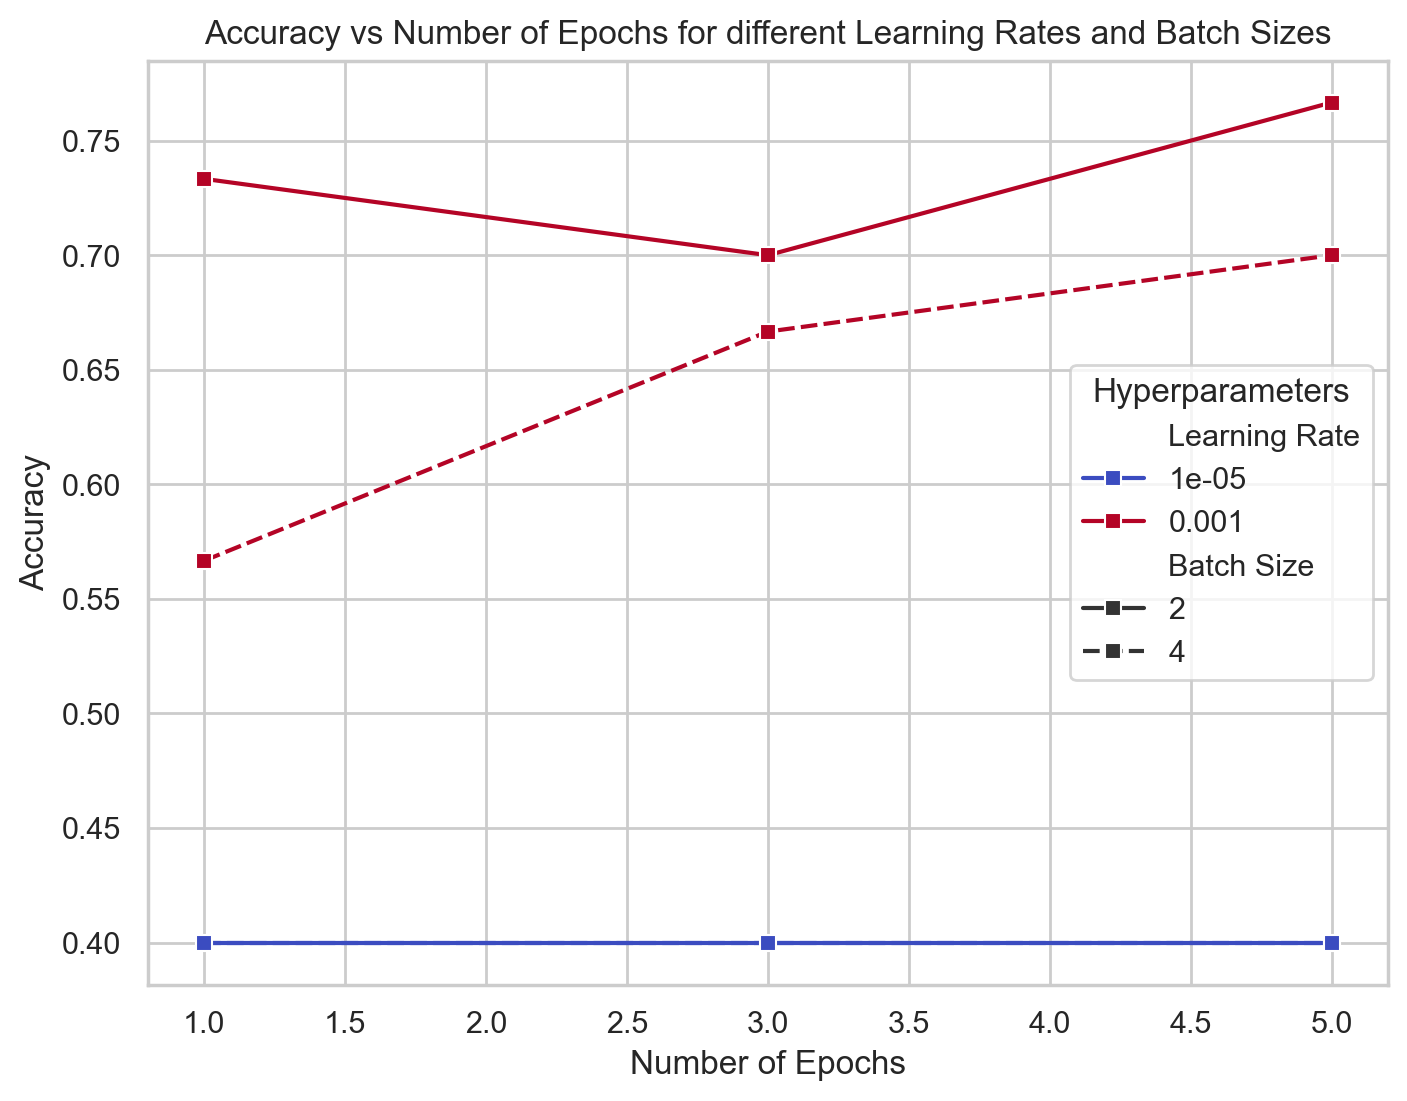

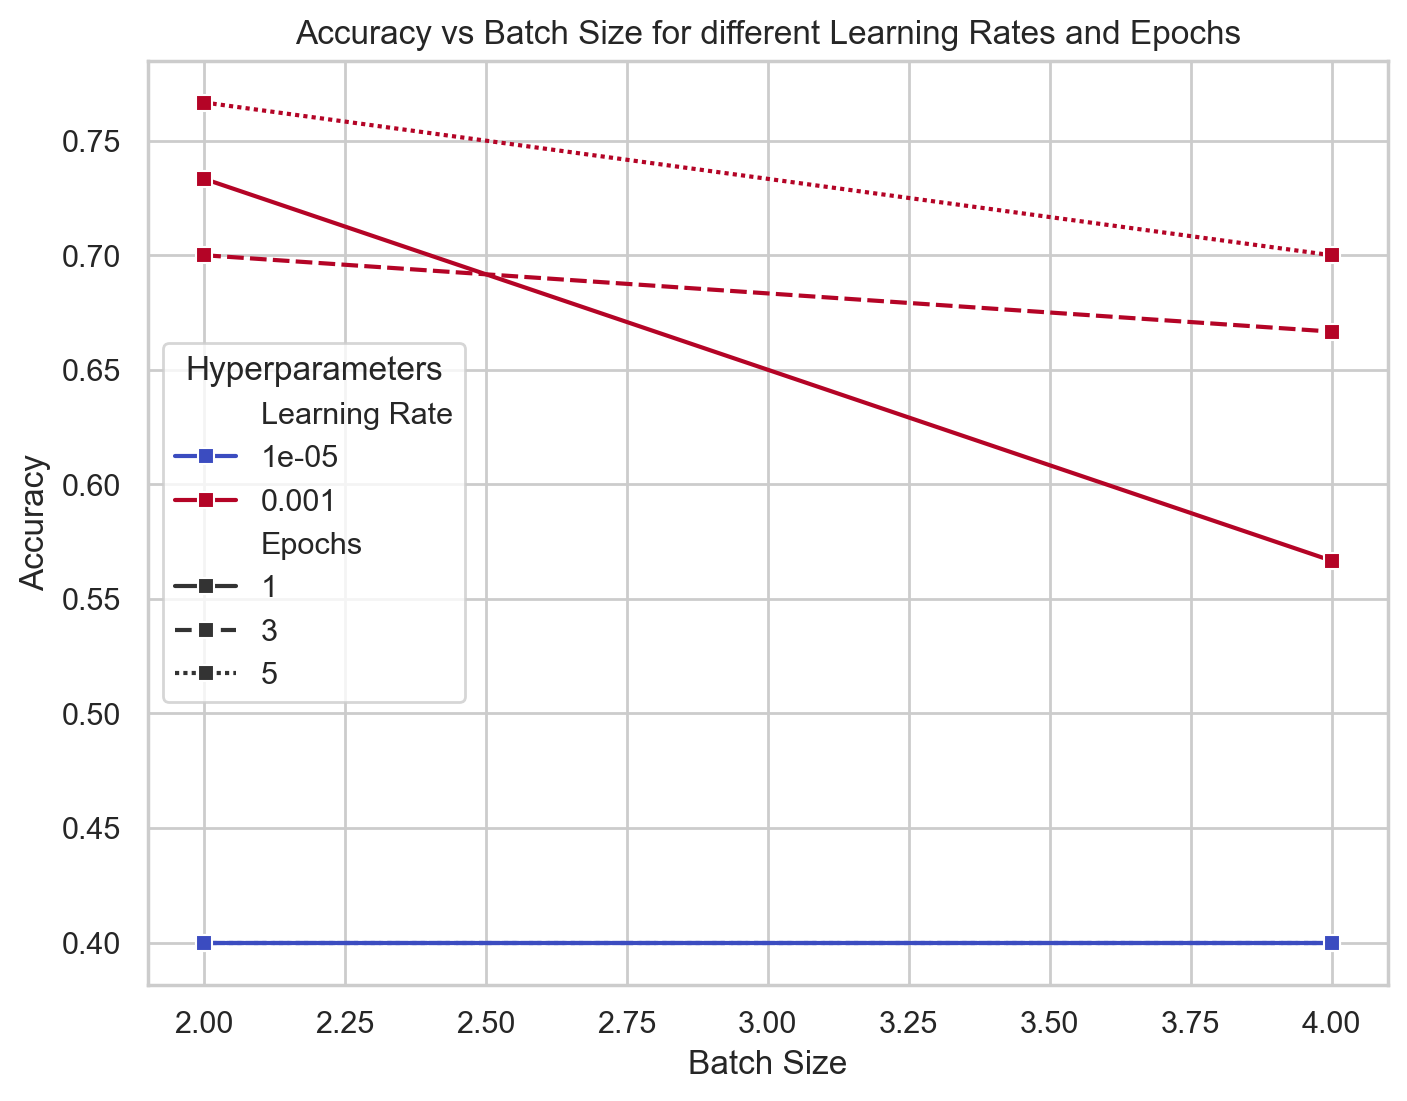

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert columns to numeric (if they are not already)
results_table2['Learning Rate'] = pd.to_numeric(results_table2['Learning Rate'], errors='coerce')
results_table2['Batch Size'] = pd.to_numeric(results_table2['Batch Size'], errors='coerce')
results_table2['Epochs'] = pd.to_numeric(results_table2['Epochs'], errors='coerce')
results_table2['Test Accuracy'] = pd.to_numeric(results_table2['Test Accuracy'], errors='coerce')

# Set seaborn style for better visualization
sns.set(style="whitegrid")

# Plot Accuracy vs Learning Rate
plt.figure(figsize=(8, 6))

sns.lineplot(
    data=results_table2, 
    x='Learning Rate', y='Test Accuracy', 
    hue='Epochs', style='Batch Size', marker="s", dashes=True, palette="coolwarm"
)
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Learning Rate for different Epochs and Batch Sizes")
plt.legend(title="Hyperparameters")
plt.grid(True)
plt.show()

# Plot Accuracy vs Epochs
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=results_table2, 
    x='Epochs', y='Test Accuracy', 
    hue='Learning Rate', style='Batch Size', marker="s", dashes=True, palette="coolwarm"
)
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Epochs for different Learning Rates and Batch Sizes")
plt.legend(title="Hyperparameters")
plt.grid(True)
plt.show()

# Plot Accuracy vs Batch Size
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=results_table2, 
    x='Batch Size', y='Test Accuracy', 
    hue='Learning Rate', style='Epochs', marker="s", dashes=True, palette="coolwarm"
)
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Batch Size for different Learning Rates and Epochs")
plt.legend(title="Hyperparameters")
plt.grid(True)
plt.show()



### Auto Mode

In [63]:
import autogluon.common as ag
from autogluon.tabular import TabularPredictor

def train_auto_mode(train_data,val_data,search_strategy,num_trials,scheduler):

    model_path = f'models/auto_training/{search_strategy}'
    if(search_strategy =='grid'):
        search_strategy = 'random'
        nn_options = {
        'num_epochs': ag.space.Categorical(2,3,4),
        'learning_rate': ag.space.Categorical(1e-4,1e-2),
        'batch_size': ag.space.Categorical(2,3,4),      
        'activation': 'relu',
        'hidden_size': 16,
        'num_layers': 2,
        }
        num_trials = 3*3*2
    else:
        nn_options = {
            'num_epochs': ag.space.Int(lower=2, upper=4),
            'learning_rate': ag.space.Real(lower=1e-4,upper=1e-2),
            'batch_size': ag.space.Int(lower=2,upper=4),      
            'activation': 'relu',
            'hidden_size': 16,
            'num_layers': 2,
        }
    
    hyperparameters = { 
                    'NN_TORCH': nn_options, 
                    } 

    time_limit = 120*60 # 2 mins

    hyperparameter_tune_kwargs = {
        'num_trials': num_trials,
        'scheduler' : scheduler,
        'searcher': search_strategy,
    }

    predictor = TabularPredictor(
        label='target',
        eval_metric='accuracy',
        problem_type='multiclass',
        path = model_path).fit(
        train_data=train_data,

        tuning_data=val_data,
        use_bag_holdout=True,  # Use validation data for tuning 

        # disable bagging
        num_bag_folds=0,
        
        # disable weighted ensembling
        num_stack_levels=0,
        fit_weighted_ensemble =False,
        fit_full_last_level_weighted_ensemble= False,
        
        verbosity=2,
        hyperparameters=hyperparameters,
        hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        time_limit=time_limit,
        )
    
    return predictor

In [64]:
import torch

def set_seed(seed_value=0):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

set_seed(42) # Set seed for same training results

In [ ]:
results_table_auto = pd.DataFrame(columns=['Batch Size', 'Learning Rate', 'Epochs', 'Test Accuracy','Validation Accuracy', 'F1 Score'])
predictors_auto = []

def train_eval_auto_model(train_data,val_data,search_strategy,num_trials,scheduler):
    retrain = True
    if os.path.exists(f'models/auto_training/{search_strategy}/predictor.pkl') and not retrain:
        print(f"Model already trained with {search_strategy}")
        predictor = TabularPredictor.load(f'models/auto_training/{search_strategy}')
    else:
        print(f"Training with {search_strategy}")
        predictor = train_auto_mode(train_data,val_data,search_strategy,num_trials,scheduler)
        
    predictor.fit_summary()
    
    accuracy,f1 = evaluate_model(predictor,test_df)

    model_name = predictor._trainer.load_model(predictor.leaderboard().loc[0, 'model'])
    val_score = predictor.leaderboard().loc[0, 'score_val']
    train_score = predictor.leaderboard(train_df).loc[0, 'score_test']
    test_score = predictor.leaderboard(test_df).loc[0, 'score_test']

    hp = model_name.params

    results_table_auto.loc[len(results_table_auto)] = {
                'Batch Size': hp['batch_size'],
                'Learning Rate': hp['learning_rate'],
                'Epochs': hp['num_epochs'],
                'Train Accuracy': hp['best_reward'],
                'Test Accuracy': accuracy,
                'Validation Accuracy':val_score,
                'F1 Score': f1,
                'Search Strategy': search_strategy,
                'Scheduler': scheduler
            }
    predictors_auto.append(predictor)
    return predictor

In [ ]:
import os
import pandas as pd
from autogluon.tabular import TabularPredictor

results_table_auto2 = pd.DataFrame(columns=['Batch Size', 'Learning Rate', 'Epochs', 'Train Accuracy', 'Test Accuracy', 'Validation Accuracy', 'F1 Score', 'Search Strategy', 'Scheduler', 'Model'])
def train_eval_auto_model_for_all(train_data, val_data, search_strategy, num_trials, scheduler):
    retrain = True
    model_path = f'models/auto_training/{search_strategy}/predictor.pkl'

    if os.path.exists(model_path) and not retrain:
        print(f"Model already trained with {search_strategy}")
        predictor = TabularPredictor.load(model_path)
    else:
        print(f"Training with {search_strategy}")
        predictor = train_auto_mode(train_data, val_data, search_strategy, num_trials, scheduler)
    
    predictor.fit_summary()
    
    accuracy, f1 = evaluate_model(predictor, test_df)

    leaderboard = predictor.leaderboard()
    
    for i in range(len(leaderboard)):  # Iterate over all models in the leaderboard
        model_name = predictor._trainer.load_model(leaderboard.loc[i, 'model'])
        val_score =  predictor.leaderboard().loc[i, 'score_test']
        train_score = predictor.leaderboard(train_df).loc[i, 'score_test']
        test_score = predictor.leaderboard(test_df).loc[i, 'score_test']

        hp = model_name.params

        results_table_auto2.loc[len(results_table_auto)] = {
            'Batch Size': hp.get('batch_size', 'N/A'),
            'Learning Rate': hp.get('learning_rate', 'N/A'),
            'Epochs': hp.get('num_epochs', 'N/A'),
            'Train Accuracy': train_score,
            'Test Accuracy': test_score,
            'Validation Accuracy': val_score,
            'F1 Score': f1,
            'Search Strategy': search_strategy,
            'Scheduler': scheduler,
            'Model': leaderboard.loc[i, 'model']
        }
    
    predictors_auto.append(predictor)
    return predictor


#### Random Search

Fitted model: NeuralNetTorch\1426b_00000 ...
	0.4	 = Validation score   (accuracy)
	8.43s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: NeuralNetTorch\1426b_00001 ...
	0.8667	 = Validation score   (accuracy)
	7.88s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\1426b_00002 ...
	1.0	 = Validation score   (accuracy)
	8.42s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\1426b_00003 ...
	0.8667	 = Validation score   (accuracy)
	8.76s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\1426b_00004 ...
	0.8667	 = Validation score   (accuracy)
	8.31s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 21.12s ... Best model: NeuralNetTorch\1426b_00002 | Estimated inference throughput: 2707.7 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("d:\UserFiles\CS203_Lab_06\models\auto_training\random")

*** Summary of fit() ***
Estimated performance of each model:
                        model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch\1426b_00002   1.000000    accuracy       0.005540  8.424416                0.005540           8.424416            1       True          3
1  NeuralNetTorch\1426b_00003   0.866667    accuracy       0.004027  8.763134                0.004027           8.763134            1       True          4
2  NeuralNetTorch\1426b_00004   0.866667    accuracy       0.008608  8.313192                0.008608           8.313192            1       True          5
3  NeuralNetTorch\1426b_00001   0.866667    accuracy       0.012528  7.882383                0.012528           7.882383            1       True          2
4  NeuralNetTorch\1426b_00000   0.400000    accuracy       0.020546  8.429955                0.020546           8.429955            1       True          1
Nu

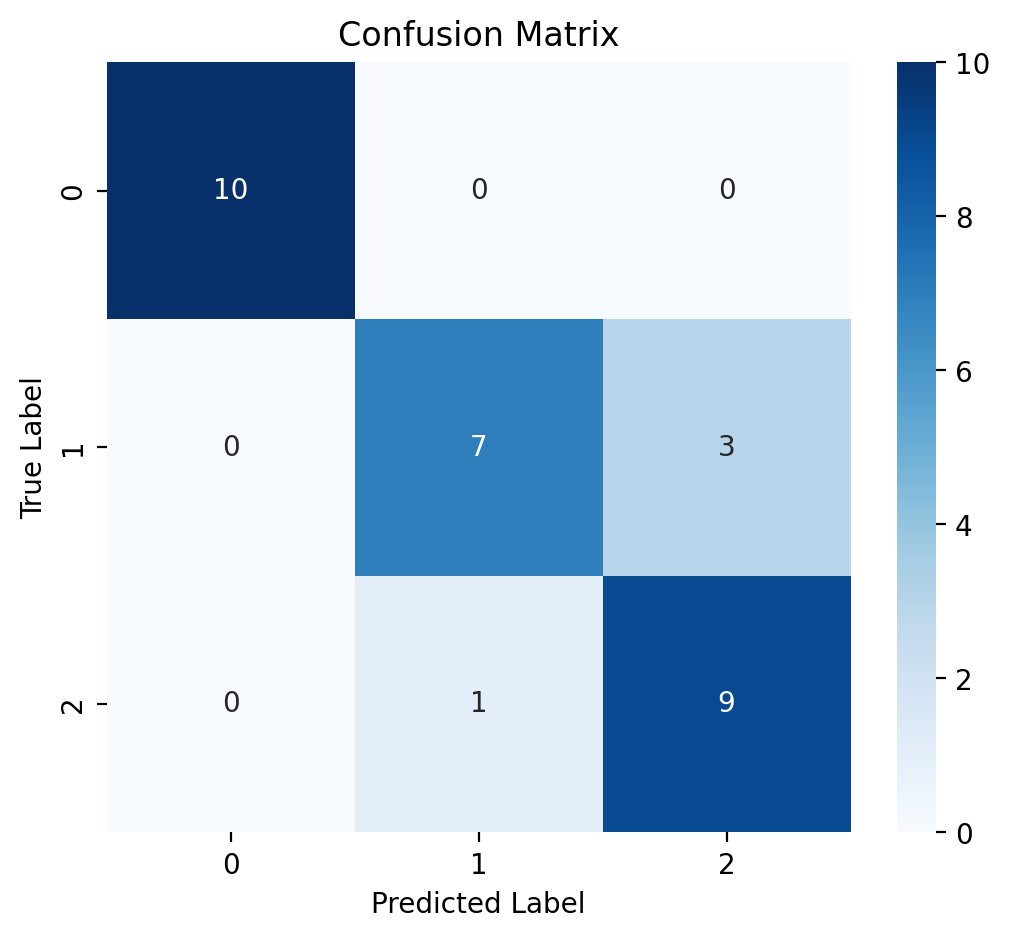

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.88      0.70      0.78        10
           2       0.75      0.90      0.82        10

    accuracy                           0.87        30
   macro avg       0.88      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------
['NeuralNetTorch\\1426b_00000', 'NeuralNetTorch\\1426b_00001', 'NeuralNetTorch\\1426b_00002', 'NeuralNetTorch\\1426b_00003', 'NeuralNetTorch\\1426b_00004']
5


In [120]:
import warnings
warnings.filterwarnings('ignore')

results_table_auto = pd.DataFrame(columns=['Batch Size','Learning Rate','Epochs','Test Accuracy','Validation Accuracy', 'F1 Score','Search Strategy','Scheduler'])
predictors_auto = []

predictor1 = train_eval_auto_model(train_df,val_df,search_strategy='random',num_trials=5,scheduler='FIFO')

models = predictor1.model_names()
print(models)
print(len(models))

In [121]:
predictor1.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch\1426b_00002,1.000000,accuracy,0.005540,8.424416,0.005540,8.424416,1,True,3
1,NeuralNetTorch\1426b_00003,0.866667,accuracy,0.004027,8.763134,0.004027,8.763134,1,True,4
2,NeuralNetTorch\1426b_00004,0.866667,accuracy,0.008608,8.313192,0.008608,8.313192,1,True,5
3,NeuralNetTorch\1426b_00001,0.866667,accuracy,0.012528,7.882383,0.012528,7.882383,1,True,2
4,NeuralNetTorch\1426b_00000,0.400000,accuracy,0.020546,8.429955,0.020546,8.429955,1,True,1


In [122]:
display(results_table_auto)

,Batch Size,Learning Rate,Epochs,Test Accuracy,Validation Accuracy,F1 Score,Search Strategy,Scheduler
0,3,0.003652,3,0.866667,1.0,0.86532,random,FIFO


#### Grid Search

Fitted model: NeuralNetTorch\21403_00000 ...
	0.4	 = Validation score   (accuracy)
	22.23s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: NeuralNetTorch\21403_00001 ...
	1.0	 = Validation score   (accuracy)
	22.86s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\21403_00002 ...
	0.9333	 = Validation score   (accuracy)
	21.91s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: NeuralNetTorch\21403_00003 ...
	1.0	 = Validation score   (accuracy)
	21.92s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: NeuralNetTorch\21403_00004 ...
	1.0	 = Validation score   (accuracy)
	22.57s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\21403_00005 ...
	1.0	 = Validation score   (accuracy)
	22.4s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: NeuralNetTorch\21403_00006 ...
	0.4667	 = Validation score   (accuracy)
	22.48s	 = Training   runtime
	0.01s	 = Validation runtime
F

*** Summary of fit() ***
Estimated performance of each model:
                         model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   NeuralNetTorch\21403_00017   1.000000    accuracy       0.004173  12.730234                0.004173          12.730234            1       True         18
1   NeuralNetTorch\21403_00013   1.000000    accuracy       0.009372  12.283520                0.009372          12.283520            1       True         14
2   NeuralNetTorch\21403_00004   1.000000    accuracy       0.010062  22.565498                0.010062          22.565498            1       True          5
3   NeuralNetTorch\21403_00001   1.000000    accuracy       0.014254  22.855690                0.014254          22.855690            1       True          2
4   NeuralNetTorch\21403_00016   1.000000    accuracy       0.016528  12.294094                0.016528          12.294094            1       True  

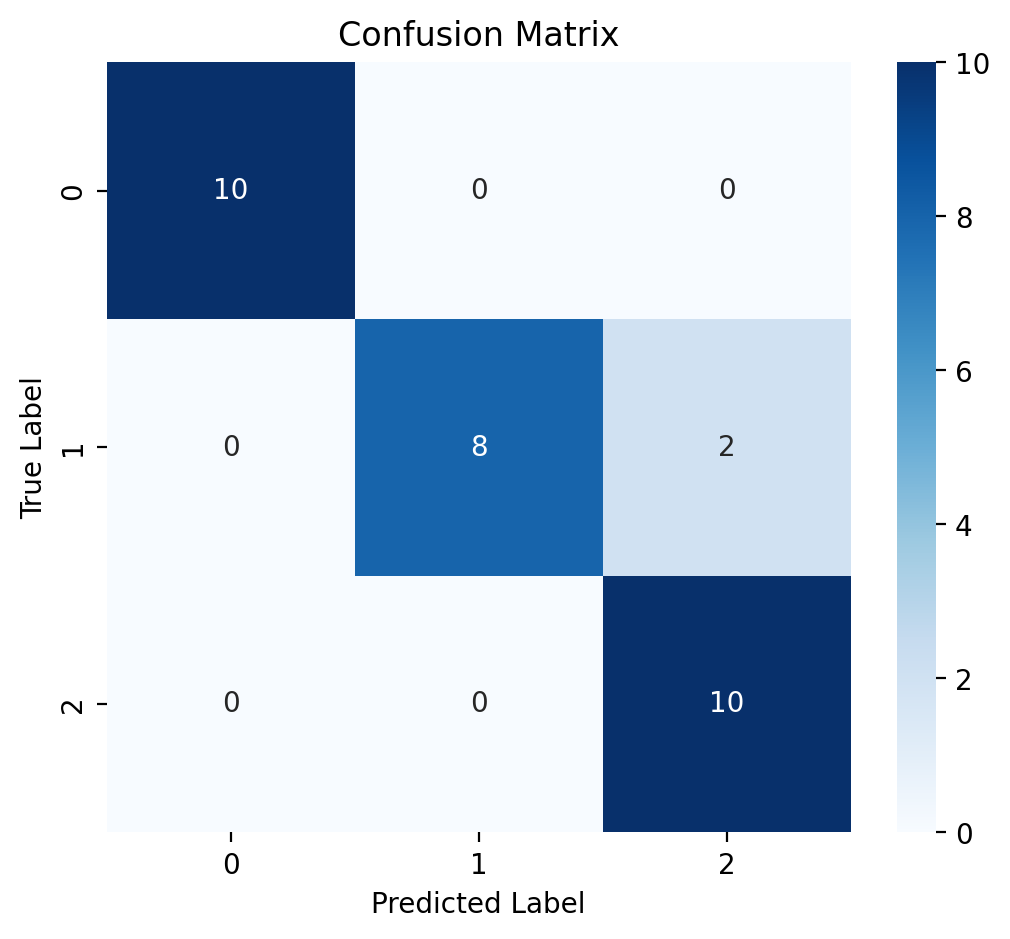

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.80      0.89        10
           2       0.83      1.00      0.91        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 2
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------


In [123]:
predictor2 = train_eval_auto_model(train_df,val_df,search_strategy='grid',num_trials=12,scheduler='FIFO')

#### Bayes Opt

Fitted model: NeuralNetTorch\38e5c39c ...
	0.4	 = Validation score   (accuracy)
	4.77s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\ad471457 ...
	1.0	 = Validation score   (accuracy)
	11.12s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\98ad48d0 ...
	0.8667	 = Validation score   (accuracy)
	5.33s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\b47f8f9e ...
	1.0	 = Validation score   (accuracy)
	4.57s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\58a2bca0 ...
	1.0	 = Validation score   (accuracy)
	10.18s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 49.01s ... Best model: NeuralNetTorch\58a2bca0 | Estimated inference throughput: 6603.8 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("d:\UserFiles\CS203_Lab_06\models\auto_training\bayes")


*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch\58a2bca0   1.000000    accuracy       0.002271  10.175624                0.002271          10.175624            1       True          5
1  NeuralNetTorch\ad471457   1.000000    accuracy       0.007438  11.117864                0.007438          11.117864            1       True          2
2  NeuralNetTorch\b47f8f9e   1.000000    accuracy       0.009213   4.570754                0.009213           4.570754            1       True          4
3  NeuralNetTorch\98ad48d0   0.866667    accuracy       0.000000   5.327588                0.000000           5.327588            1       True          3
4  NeuralNetTorch\38e5c39c   0.400000    accuracy       0.007887   4.771711                0.007887           4.771711            1       True          1
Number of mode

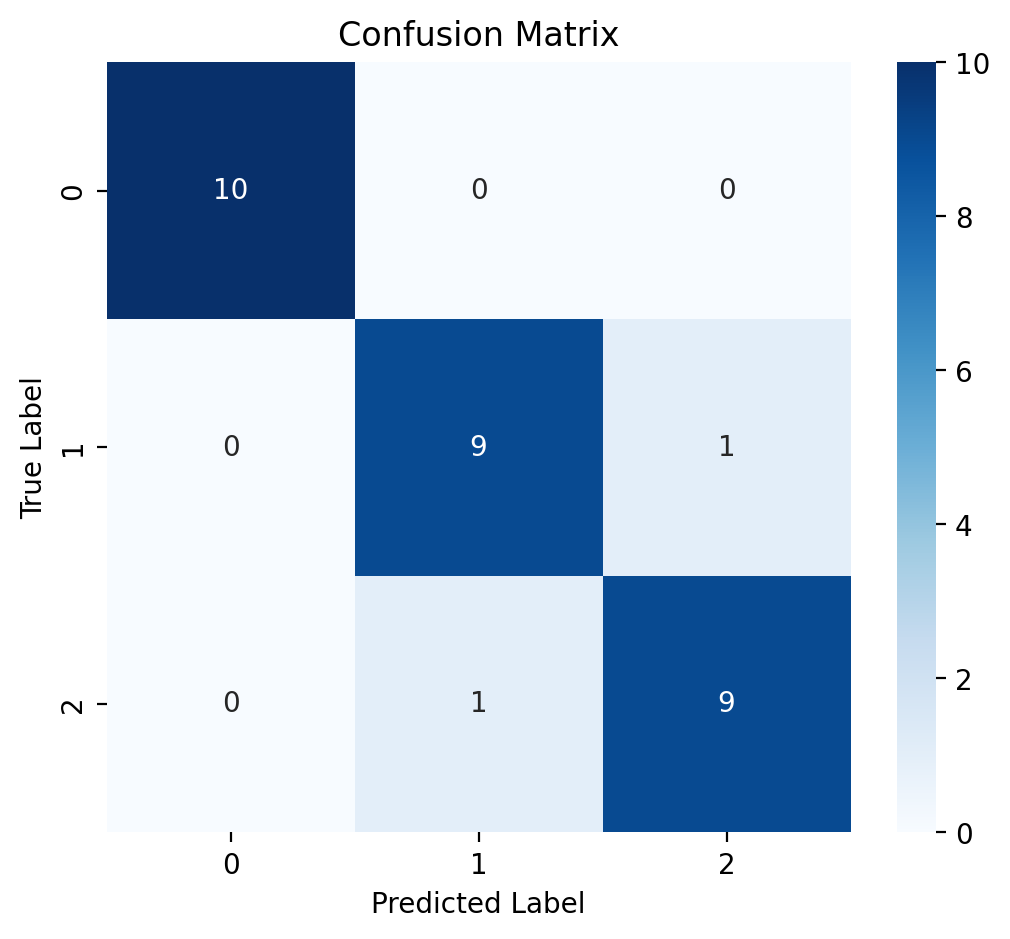

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 1
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------


In [124]:
predictor3 = train_eval_auto_model(train_df,val_df,search_strategy='bayes',num_trials=5,scheduler='FIFO')

#### Bayes Optimization and Hyperband

Fitted model: NeuralNetTorch\970d5f7b ...
	0.4	 = Validation score   (accuracy)
	9.47s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\96751250 ...
	0.8667	 = Validation score   (accuracy)
	5.03s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\2a0048b3 ...
	1.0	 = Validation score   (accuracy)
	5.15s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\875bb9fa ...
	0.9333	 = Validation score   (accuracy)
	4.62s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\a37759a3 ...
	0.7333	 = Validation score   (accuracy)
	10.17s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 49.95s ... Best model: NeuralNetTorch\2a0048b3 | Estimated inference throughput: 2452.9 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("d:\UserFiles\CS203_Lab_06\models\auto_training\bayes")


*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch\2a0048b3   1.000000    accuracy       0.006115   5.148208                0.006115           5.148208            1       True          3
1  NeuralNetTorch\875bb9fa   0.933333    accuracy       0.008018   4.621692                0.008018           4.621692            1       True          4
2  NeuralNetTorch\96751250   0.866667    accuracy       0.004359   5.029089                0.004359           5.029089            1       True          2
3  NeuralNetTorch\a37759a3   0.733333    accuracy       0.010305  10.171045                0.010305          10.171045            1       True          5
4  NeuralNetTorch\970d5f7b   0.400000    accuracy       0.006042   9.466975                0.006042           9.466975            1       True          1
Number of mode

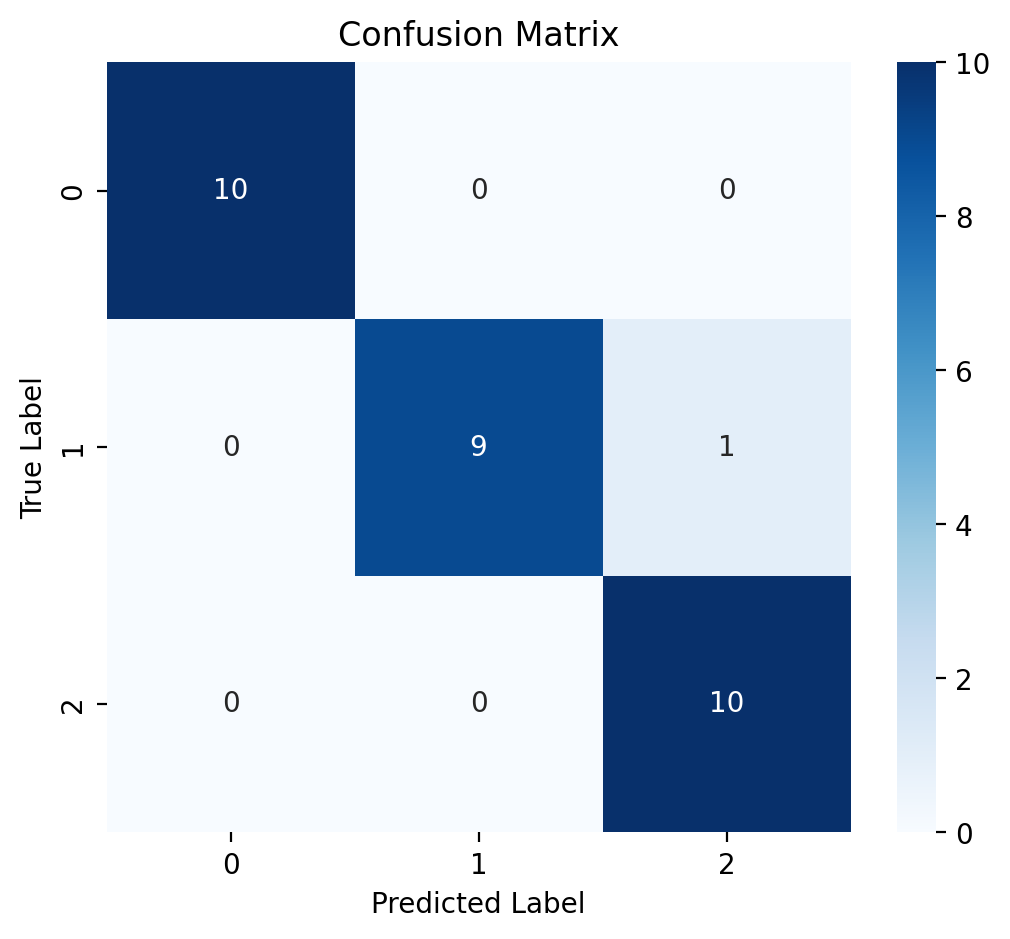

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Sample 1: Truth: 2, Predicted: 2
Sample 5: Truth: 1, Predicted: 1
Sample 10: Truth: 2, Predicted: 2
Sample 15: Truth: 0, Predicted: 0
Sample 20: Truth: 0, Predicted: 0
--------------------------------------------------


In [125]:
predictor4 = train_eval_auto_model(train_df,val_df,search_strategy='bayes',num_trials=5,scheduler='ASHA')

In [159]:
train_accuracies = []
print(len(predictors_auto))
for predictor in predictors_auto:
    train_score = predictor.leaderboard(train_df).loc[0, 'score_test']  # Extract train accuracy
    train_accuracies.append(train_score)

results_table_auto['Train Accuracy'] = train_accuracies
display(results_table_auto)

4


,Batch Size,Learning Rate,Epochs,Test Accuracy,Validation Accuracy,F1 Score,Search Strategy,Scheduler,Train Accuracy
0,3,0.003652,3,0.866667,1.0,0.865320,random,FIFO,0.914286
1,4,0.010000,3,0.933333,1.0,0.932660,grid,FIFO,0.980952
2,4,0.006828,3,0.933333,1.0,0.933333,bayes,FIFO,0.971429
3,2,0.009670,3,0.966667,1.0,0.966583,bayes,ASHA,0.961905


In [169]:
print(len(predictors))

12


In [170]:
print(len(predictors_auto))

4


In [186]:
search_strategy = ['random', 'grid', 'bayes','bayes_hyperband']
scheduler = ['FIFO','FIFO','FIFO', 'ASHA']

results_tables = []
for i in range(len(predictors_auto)):
    predictor = predictors_auto[i]
    leaderboard = predictor.leaderboard()
    print(len(leaderboard))
    results_table_auto2 = pd.DataFrame(columns=['Batch Size', 'Learning Rate', 'Epochs', 'Train Accuracy', 'Test Accuracy', 'Validation Accuracy', 'F1 Score', 'Search Strategy', 'Scheduler', 'Model'])

    for j in range(len(leaderboard)):
        model_name = predictor._trainer.load_model(leaderboard.loc[j, 'model'])
        val_score =  predictor.leaderboard().loc[j, 'score_val']
        train_score = predictor.leaderboard(train_df).loc[j, 'score_test']
        test_score = predictor.leaderboard(test_df).loc[j, 'score_test']

        hp = model_name.params

        results_table_auto2.loc[len(results_table_auto2)] = {
            'Batch Size': hp.get('batch_size', 'N/A'),
            'Learning Rate': hp.get('learning_rate', 'N/A'),
            'Epochs': hp.get('num_epochs', 'N/A'),
            'Train Accuracy': train_score,
            'Test Accuracy': test_score,
            'Validation Accuracy': val_score,
            'F1 Score': f1,
            'Search Strategy': search_strategy[i],
            'Scheduler': scheduler[i],
            'Model': leaderboard.loc[j, 'model']
        }

    display(results_table_auto2)
    results_tables.append(results_table_auto2)

5


,Batch Size,Learning Rate,Epochs,Train Accuracy,Test Accuracy,Validation Accuracy,F1 Score,Search Strategy,Scheduler,Model
0,3,0.003652,3,0.914286,0.866667,1.000000,0.329275,random,FIFO,NeuralNetTorch\1426b_00002
1,3,0.007501,4,0.885714,0.800000,0.866667,0.329275,random,FIFO,NeuralNetTorch\1426b_00003
2,4,0.005474,2,0.866667,0.800000,0.866667,0.329275,random,FIFO,NeuralNetTorch\1426b_00004
3,4,0.007973,2,0.790476,0.700000,0.866667,0.329275,random,FIFO,NeuralNetTorch\1426b_00001
4,2,0.000100,2,0.438095,0.433333,0.400000,0.329275,random,FIFO,NeuralNetTorch\1426b_00000


18


,Batch Size,Learning Rate,Epochs,Train Accuracy,Test Accuracy,Validation Accuracy,F1 Score,Search Strategy,Scheduler,Model
0,4,0.0100,3,0.980952,0.966667,1.000000,0.329275,grid,FIFO,NeuralNetTorch\21403_00017
1,4,0.0100,2,0.971429,0.933333,1.000000,0.329275,grid,FIFO,NeuralNetTorch\21403_00013
2,3,0.0100,4,0.971429,0.933333,1.000000,0.329275,grid,FIFO,NeuralNetTorch\21403_00004
3,2,0.0100,4,0.961905,0.933333,1.000000,0.329275,grid,FIFO,NeuralNetTorch\21403_00001
4,4,0.0100,2,0.942857,0.933333,1.000000,0.329275,grid,FIFO,NeuralNetTorch\21403_00016
5,2,0.0100,3,0.923810,0.933333,1.000000,0.329275,grid,FIFO,NeuralNetTorch\21403_00015
6,4,0.0100,3,0.914286,0.900000,1.000000,0.329275,grid,FIFO,NeuralNetTorch\21403_00003
7,2,0.0100,3,0.914286,0.900000,1.000000,0.329275,grid,FIFO,NeuralNetTorch\21403_00005
8,3,0.0100,2,0.885714,0.866667,0.933333,0.329275,grid,FIFO,NeuralNetTorch\21403_00002
9,2,0.0100,3,0.714286,0.733333,0.800000,0.329275,grid,FIFO,NeuralNetTorch\21403_00009


5


,Batch Size,Learning Rate,Epochs,Train Accuracy,Test Accuracy,Validation Accuracy,F1 Score,Search Strategy,Scheduler,Model
0,4,0.006828,3,0.971429,0.933333,1.000000,0.329275,bayes,FIFO,NeuralNetTorch\58a2bca0
1,3,0.008441,4,0.971429,0.933333,1.000000,0.329275,bayes,FIFO,NeuralNetTorch\ad471457
2,2,0.009400,3,0.952381,0.900000,1.000000,0.329275,bayes,FIFO,NeuralNetTorch\b47f8f9e
3,3,0.004101,2,0.819048,0.733333,0.866667,0.329275,bayes,FIFO,NeuralNetTorch\98ad48d0
4,2,0.000100,2,0.438095,0.433333,0.400000,0.329275,bayes,FIFO,NeuralNetTorch\38e5c39c


5


,Batch Size,Learning Rate,Epochs,Train Accuracy,Test Accuracy,Validation Accuracy,F1 Score,Search Strategy,Scheduler,Model
0,2,0.009670,3,0.961905,0.966667,1.000000,0.329275,bayes_hyperband,ASHA,NeuralNetTorch\2a0048b3
1,4,0.008038,4,0.933333,0.833333,0.933333,0.329275,bayes_hyperband,ASHA,NeuralNetTorch\875bb9fa
2,3,0.001364,4,0.780952,0.700000,0.866667,0.329275,bayes_hyperband,ASHA,NeuralNetTorch\96751250
3,3,0.001676,2,0.742857,0.666667,0.733333,0.329275,bayes_hyperband,ASHA,NeuralNetTorch\a37759a3
4,2,0.000100,2,0.438095,0.433333,0.400000,0.329275,bayes_hyperband,ASHA,NeuralNetTorch\970d5f7b


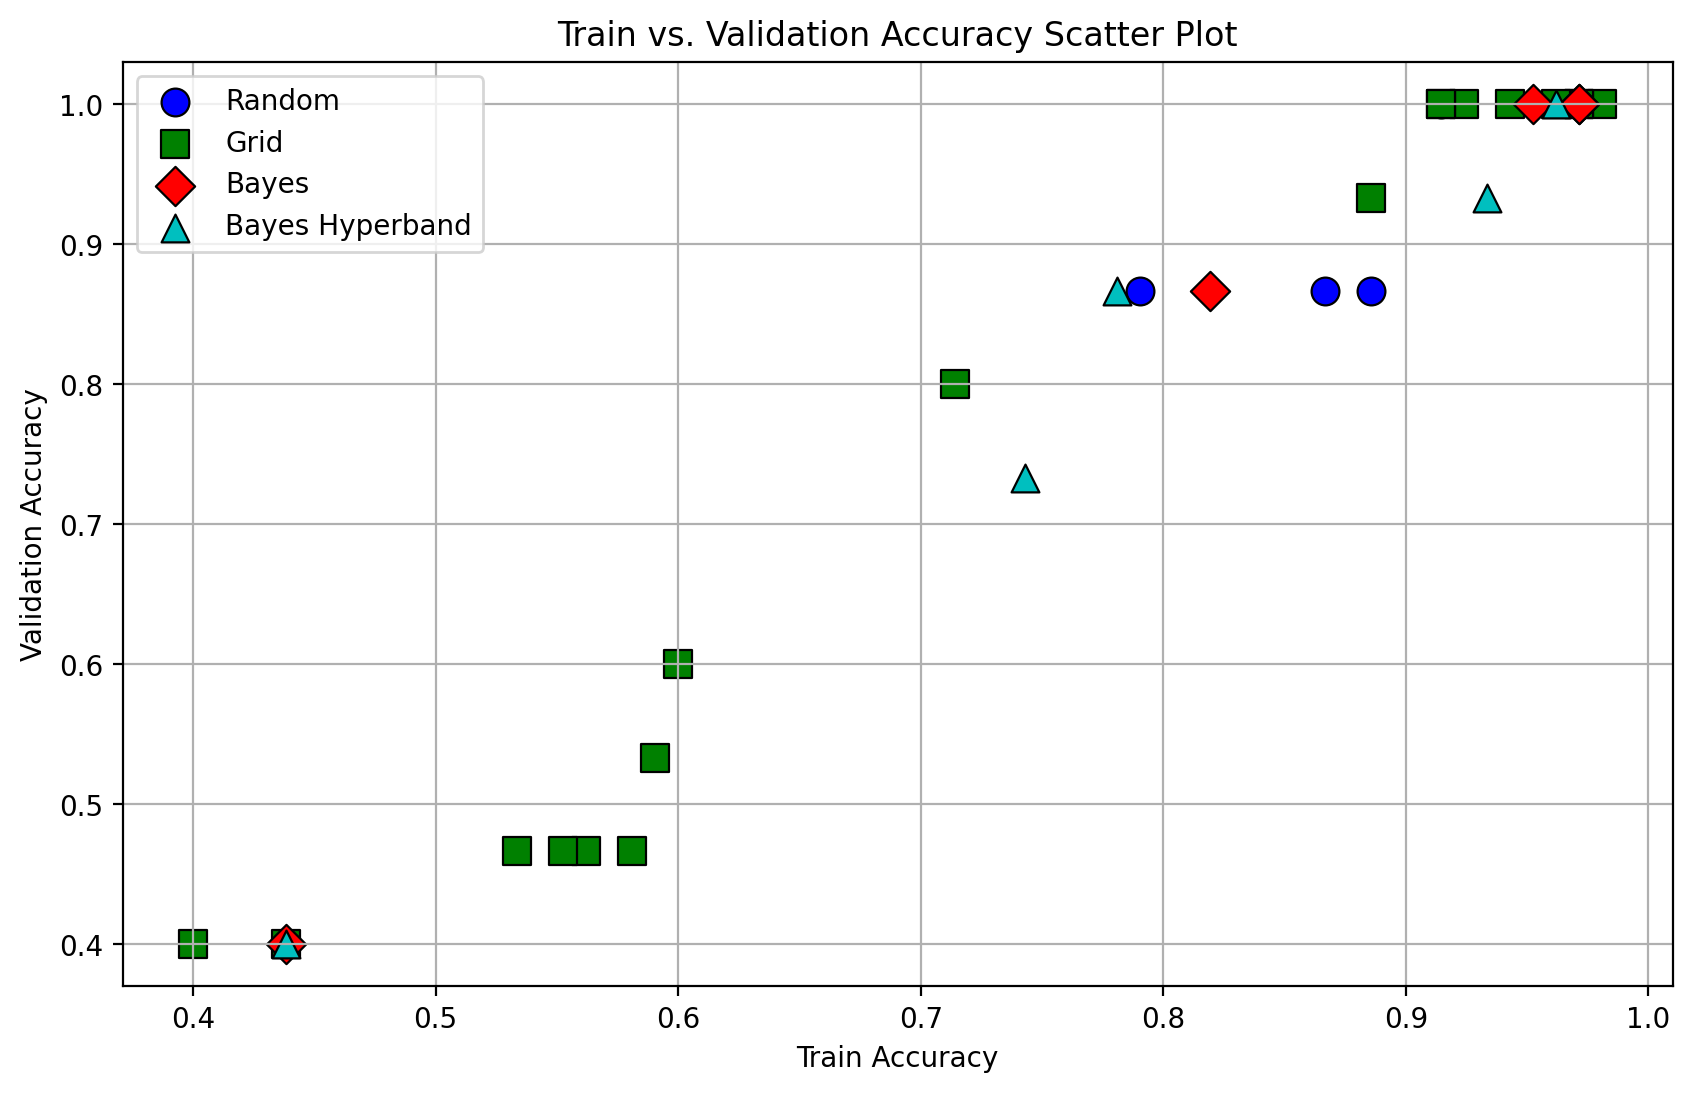

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def plot_model_accuracies(*dfs, labels=None):

    plt.figure(figsize=(10, 6))
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Define colors for different datasets
    markers = ['o', 's', 'D', '^', 'v', 'P']  # Different markers for datasets

    for i, df in enumerate(dfs):
        label = labels[i] if labels else f"Dataset {i+1}"
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        sns.scatterplot(
            x=df["Train Accuracy"],
            y=df["Validation Accuracy"],
            label=label,
            color=color,
            marker=marker,
            s=100,  # Size of points
            edgecolor="black"
        )

    plt.xlabel("Train Accuracy")
    plt.ylabel("Validation Accuracy")
    plt.title("Train vs. Validation Accuracy Scatter Plot")
    plt.legend()
    plt.grid(True)
    plt.show()

df1 = results_tables[0]
df2 = results_tables[1]
df3 = results_tables[2]
df4 = results_tables[3]

plot_model_accuracies(df1, df2, df3, df4, labels=['Random', 'Grid', 'Bayes', 'Bayes Hyperband'])